In [1]:
library(DESeq2)
library(RColorBrewer)
library(reshape2)
library("gplots")
library("GGally")                      # Load GGally package
library(goseq)
library(readxl)
library(tidyverse)
library("pheatmap")

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: 'BiocGenerics'


The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs


The following objects are masked from 'package:base':

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: 'S4Vectors'


The following objects are masked from 'package:base':

    expand.grid, I, unname


Loading required package: IRanges


Attaching package: 'IRanges'


The following object is masked from 'package:grDevices':

    windows


Loading required package: GenomicRanges

Loading req

In [2]:
library(ggfortify)

In [26]:
library(corrplot)

corrplot 0.92 loaded



In [3]:
options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 300)

In [4]:
PRO_COLOR = 'MediumSeaGreen'
ALT_COLOR = 'Gold'
HCOLOR = '#E26A2C'
HCOLOR = '#984215'
 
HCOLOR_light = '#FDA65D'
PCOLOR = '#99cc99'
PCOLOR_light = '#aad5aa'

tpal = brewer.pal(5, "Purples")
gpal = brewer.pal(4, 'Dark2')
ann_colors = list(
    Timepoint = c('1'=tpal[1], '2'=tpal[2], '3'=tpal[3], 
                  '4'=tpal[4], '5'=tpal[5]),
    Group = c(A = HCOLOR_light, C = HCOLOR),
    treatment = c(ref = gpal[2], long.term=gpal[4])
)
#forder = ['med4 (AX)', 'med4 (CC)', '1A3 (CC)', '1A3 (AX)']
#fpal = [PCOLOR_light, PRO_COLOR, HCOLOR, HCOLOR_light,  ]


In [5]:
list.files('data')

[1] "A_axenic_proteome.txt"                                                                          
 [2] "A_axenic_proteome_norm.txt"                                                                     
 [3] "C_ALT_proteome.txt"                                                                             
 [4] "C_ALT_proteome_norm.txt"                                                                        
 [5] "C_PRO_proteome.txt"                                                                             
 [6] "C_PRO_proteome_norm.txt"                                                                        
 [7] "Nov22_Processing.xlsx"                                                                          
 [8] "P_axenic_proteome.txt"                                                                          
 [9] "P_axenic_proteome_norm.txt"                                                                     
[10] "uniprot-compressed_true_download_true_fields_accession_2Cid_2Cprotei-2023.01.11-12.43.22.99.txt"

In [6]:

dfA = read.csv(file.path('data', 'A_axenic_proteome_norm.txt'), sep='\t', comment.char = '#' )
dfC = read.csv(file.path('data', 'C_ALT_proteome_norm.txt'), sep='\t', comment.char = '#'  )


In [7]:
fname_hcounts = file.path('..', 'RNASEQ', 'data', 'HOT1A3_counts_combined.txt')
hcdf = read.csv(fname_hcounts, sep='\t' )
hgenes = hcdf[,c(1,2,3,4,5)]
hpath_fname = file.path('..', 'genomes', 'HOT1A3', 'HOT1A3_pathways.csv')
hpath_df = read.csv(hpath_fname)
hpath_df = left_join(hgenes, hpath_df, by='protein_id')

Warning message in left_join(hgenes, hpath_df, by = "protein_id"):
"Each row in `x` is expected to match at most 1 row in `y`.
ℹ Row 1 of `x` matches multiple rows.
ℹ If multiple matches are expected, set `multiple = "all"` to silence this warning."


In [8]:
hpath_df_to_export = hpath_df %>% 
     group_by(gene_id) %>% 
     mutate(
         main = paste0(unique(main), collapse = ";"),
         sub = paste0(unique(sub), collapse = ";"),
         path = paste0(unique(path), collapse = ";"),
         ecpath = paste0(unique(ecpath), collapse = ";")
     ) %>%
    ungroup() %>%
    distinct(gene_id, .keep_all = TRUE)


In [9]:
names(dfA)
names(dfC)

[1] "A1_1"       "A1_2"       "A1_3"       "A2_1"       "A2_2"      
 [6] "A2_3"       "A3_1"       "A3_2"       "A3_3"       "A5_1"      
[11] "A5_2"       "A5_3"       "Species"    "name"       "protein_id"

[1] "C1_1"       "C1_2"       "C1_3"       "C2_1"       "C2_2"      
 [6] "C2_3"       "C3_1"       "C3_2"       "C3_3"       "C4_1"      
[11] "C4_2"       "C4_3"       "C5_1"       "C5_2"       "C5_3"      
[16] "Species"    "name"       "protein_id"

In [10]:
mdf = bind_rows(
    pivot_longer(dfA, cols = starts_with('A'), names_to = 'Sample', values_to = 'Intensity'),
    pivot_longer(dfC, cols = starts_with('C'), names_to = 'Sample', values_to = 'Intensity')
)


In [11]:
#mdf = left_join(mdf, hpath_df_to_export, by='protein_id')

In [12]:
mdf = mdf %>% 
   mutate(Group = substr(mdf$Sample, 1,1)) %>%
   mutate(Timepoint = substr(mdf$Sample, 2,2)) %>%
   mutate(replicate = substr(mdf$Sample, 4,4)) %>%
   mutate(Group.Timepoint = substr(mdf$Sample, 1,2)) 

In [13]:
head(mdf)

Species,name,protein_id,Sample,Intensity,Group,Timepoint,replicate,Group.Timepoint
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
ALT,TonB-dependent receptor,WP_061485087.1,A1_1,5.240101,A,1,1,A1
ALT,TonB-dependent receptor,WP_061485087.1,A1_2,5.525033,A,1,2,A1
ALT,TonB-dependent receptor,WP_061485087.1,A1_3,5.519694,A,1,3,A1
ALT,TonB-dependent receptor,WP_061485087.1,A2_1,6.025249,A,2,1,A2
ALT,TonB-dependent receptor,WP_061485087.1,A2_2,6.314917,A,2,2,A2
ALT,TonB-dependent receptor,WP_061485087.1,A2_3,6.192062,A,2,3,A2


In [14]:
names(mdf)

[1] "Species"         "name"            "protein_id"      "Sample"         
[5] "Intensity"       "Group"           "Timepoint"       "replicate"      
[9] "Group.Timepoint"

Warning message:
"Setting row names on a tibble is deprecated."


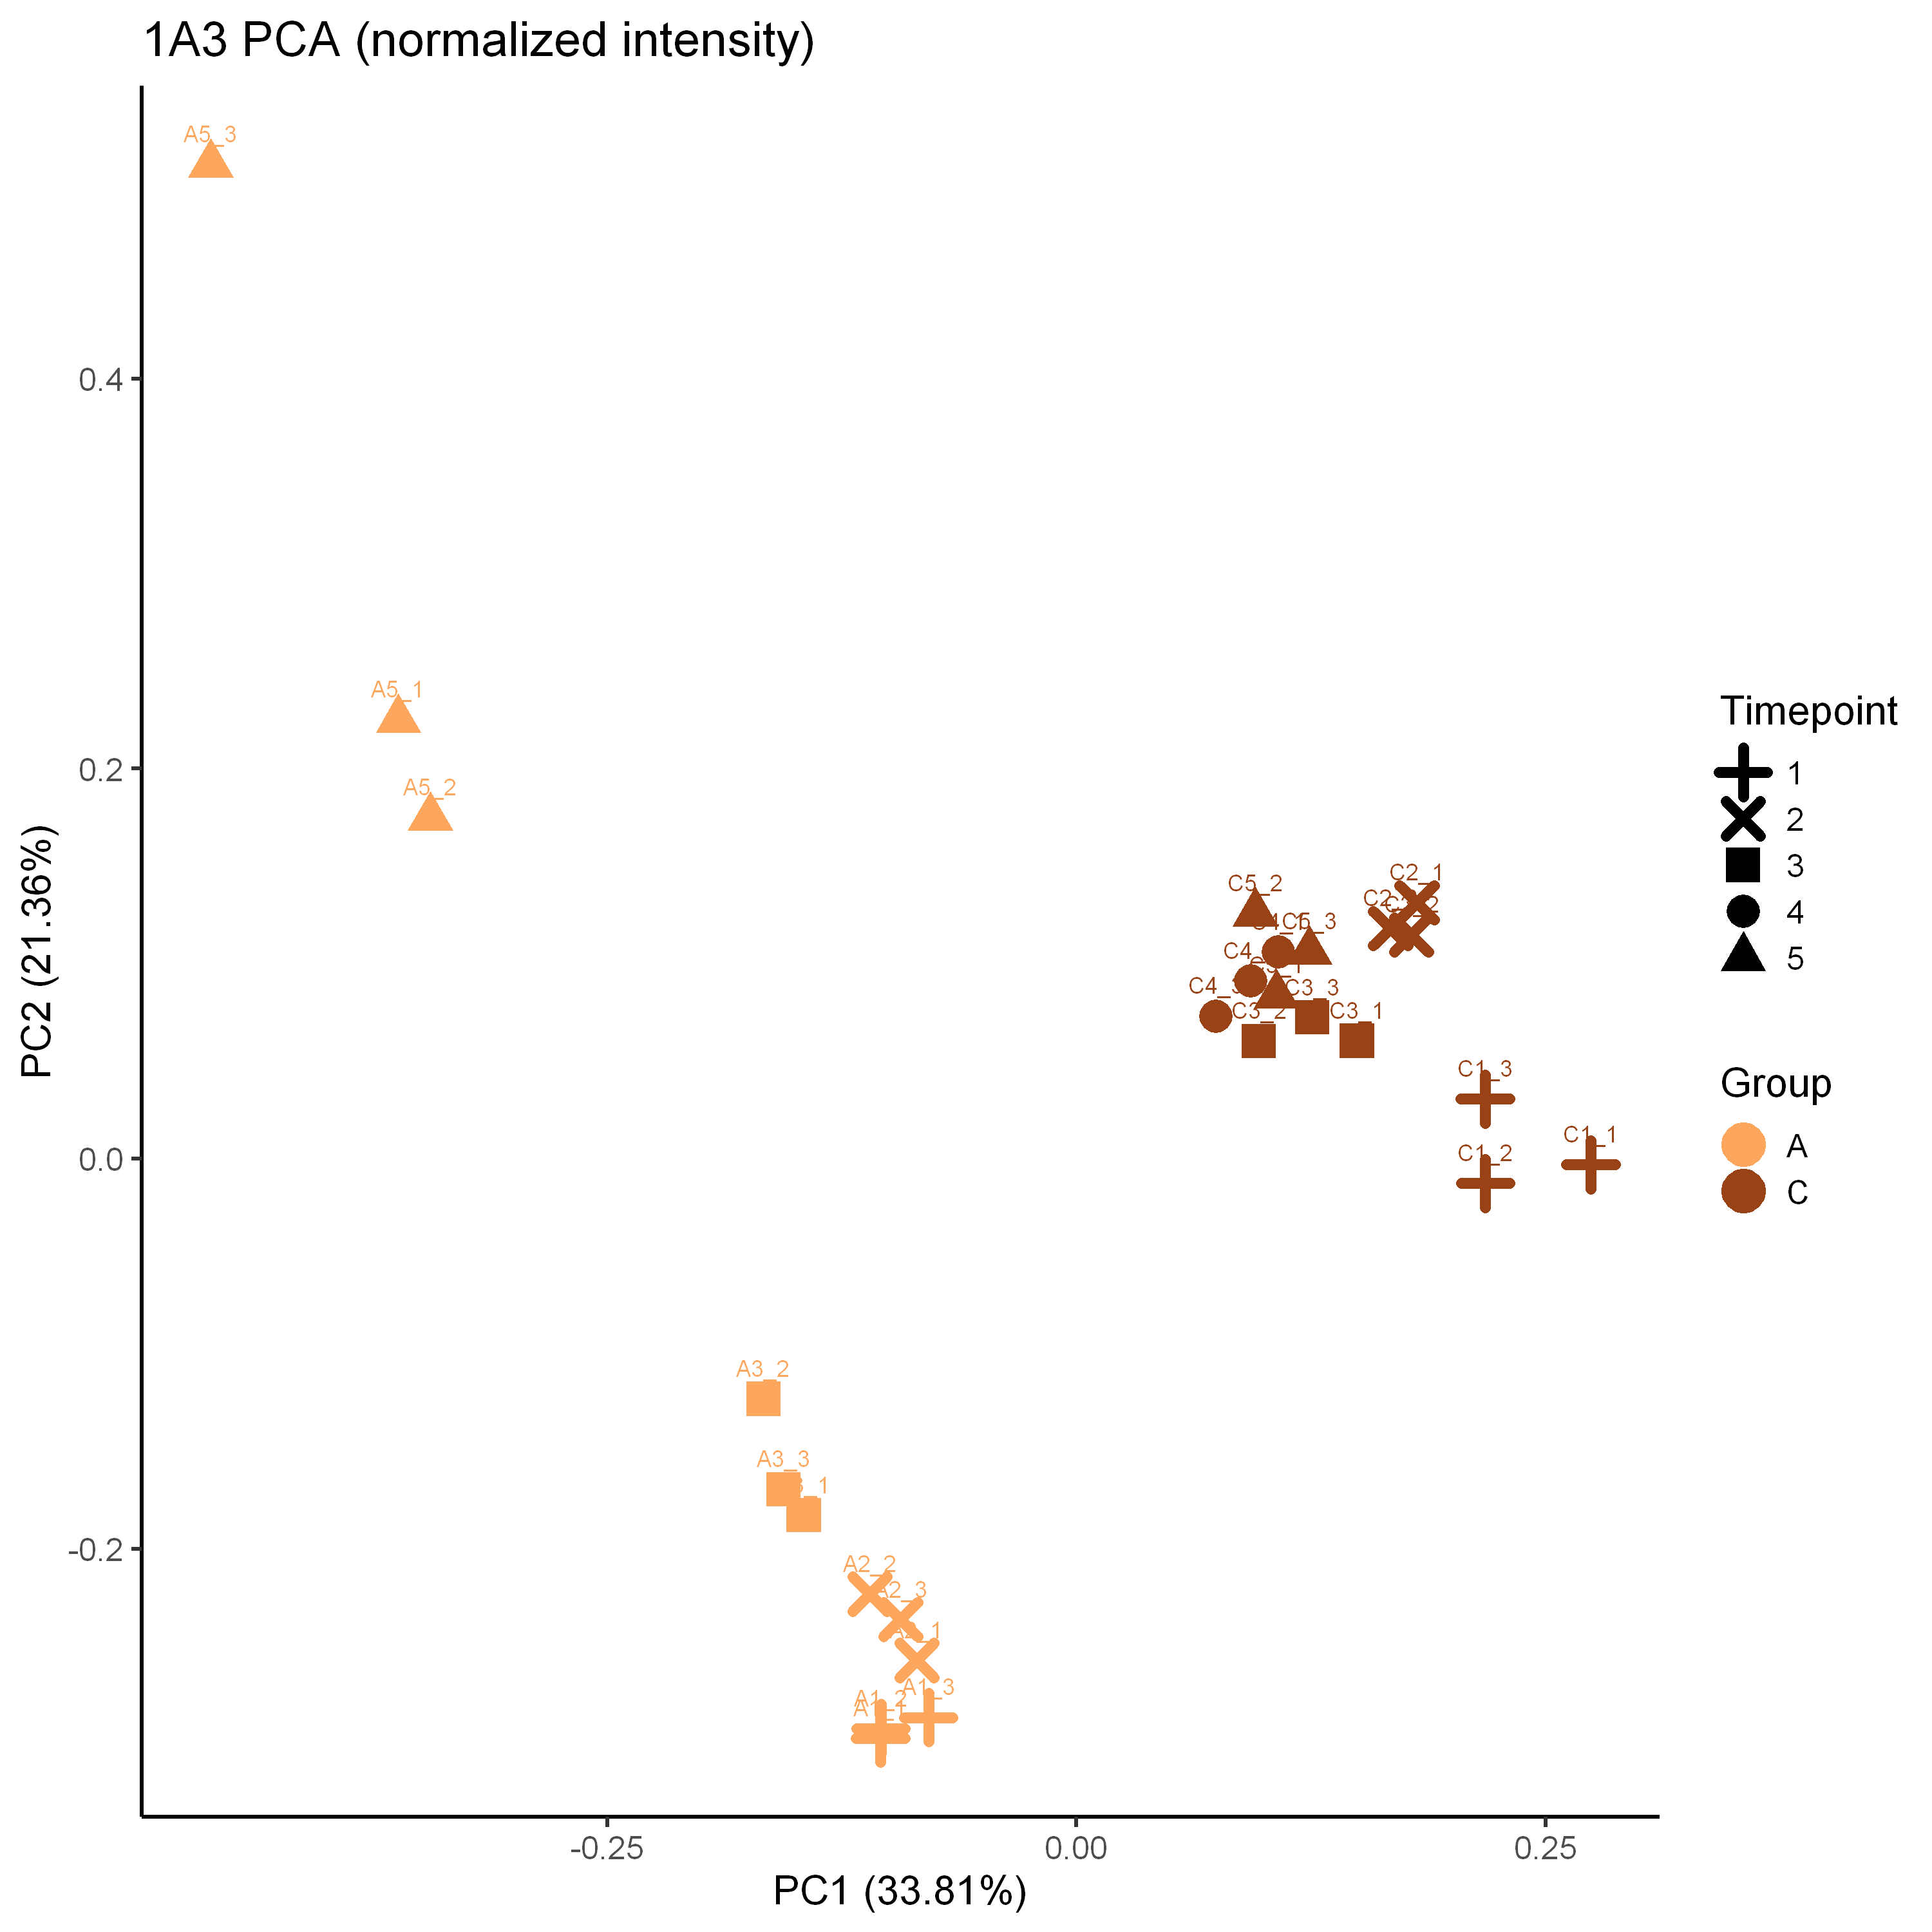

In [15]:
df = pivot_wider(
    mdf, id_cols=c('Sample', 'Group','Timepoint','replicate','Group.Timepoint'), 
    names_from='protein_id', values_from = 'Intensity')
X = df %>% select(starts_with('WP_')) 
row.names(X) = df$Sample
#X
#    as.data.frame
pca_res <- prcomp(X, scale. = TRUE)
p = autoplot(pca_res, data=df, colour='Group', shape='Timepoint', label=TRUE, size =4, 
         label.vjust = -1.3, label.size = 3) +
  scale_color_manual(values = ann_colors$Group) +
  scale_shape_manual(values=c(3,4, 15,16,17))+
  ggtitle("1A3 PCA (normalized intensity)") +
  theme_classic(base_size = 15)  
p$layers[[1]]$aes_params$stroke <- 3
p

Warning message:
"Setting row names on a tibble is deprecated."


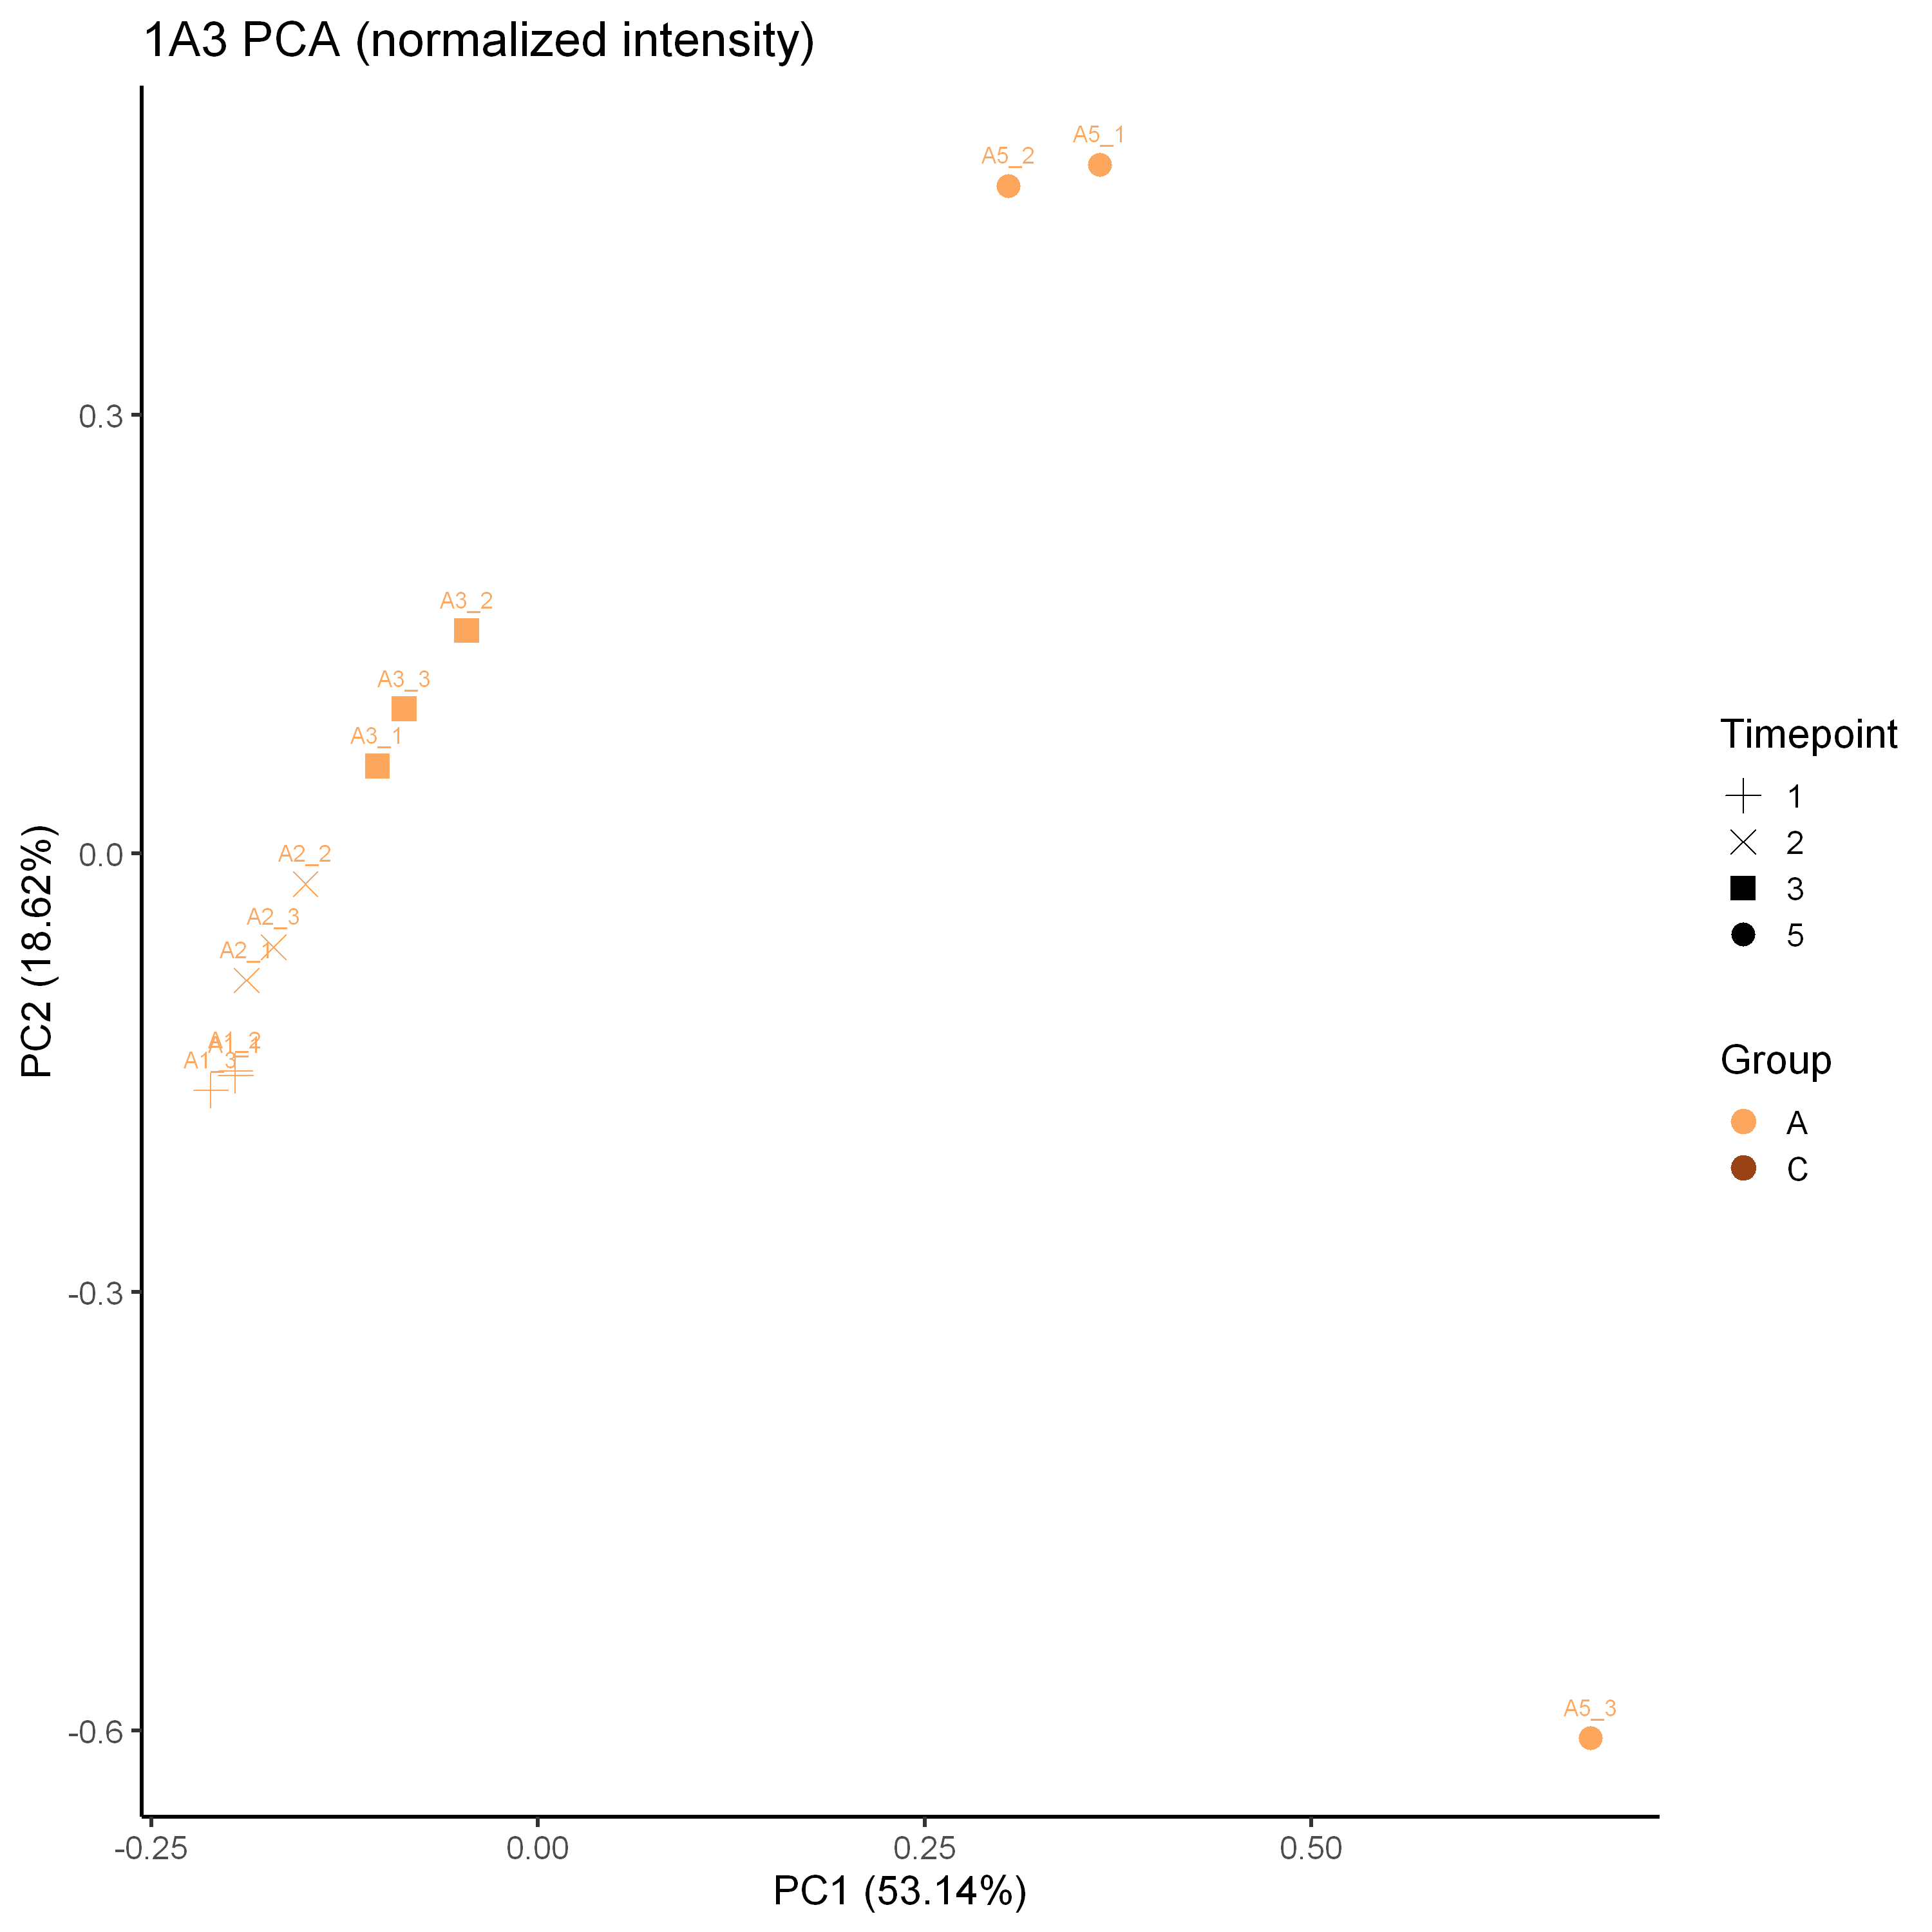

In [89]:
df = pivot_wider(
    mdf, id_cols=c('Sample', 'Group','Timepoint','replicate','Group.Timepoint'), 
    names_from='protein_id', values_from = 'Intensity') 
df = df %>% filter(Group=='A')
X = df %>% select(starts_with('WP_')) 
row.names(X) = df$Sample
#X
#    as.data.frame
pca_res <- prcomp(X, scale. = TRUE)
autoplot(pca_res, data=df, colour='Group', shape='Timepoint', label=TRUE, size =4, 
         label.vjust = -1.3, label.size = 3) +
  scale_color_manual(values = ann_colors$Group) +
  scale_shape_manual(values=c(3,4, 15,16,17))+
  ggtitle("1A3 PCA (normalized intensity)") +
  theme_classic(base_size = 15)  


Warning message:
"Setting row names on a tibble is deprecated."


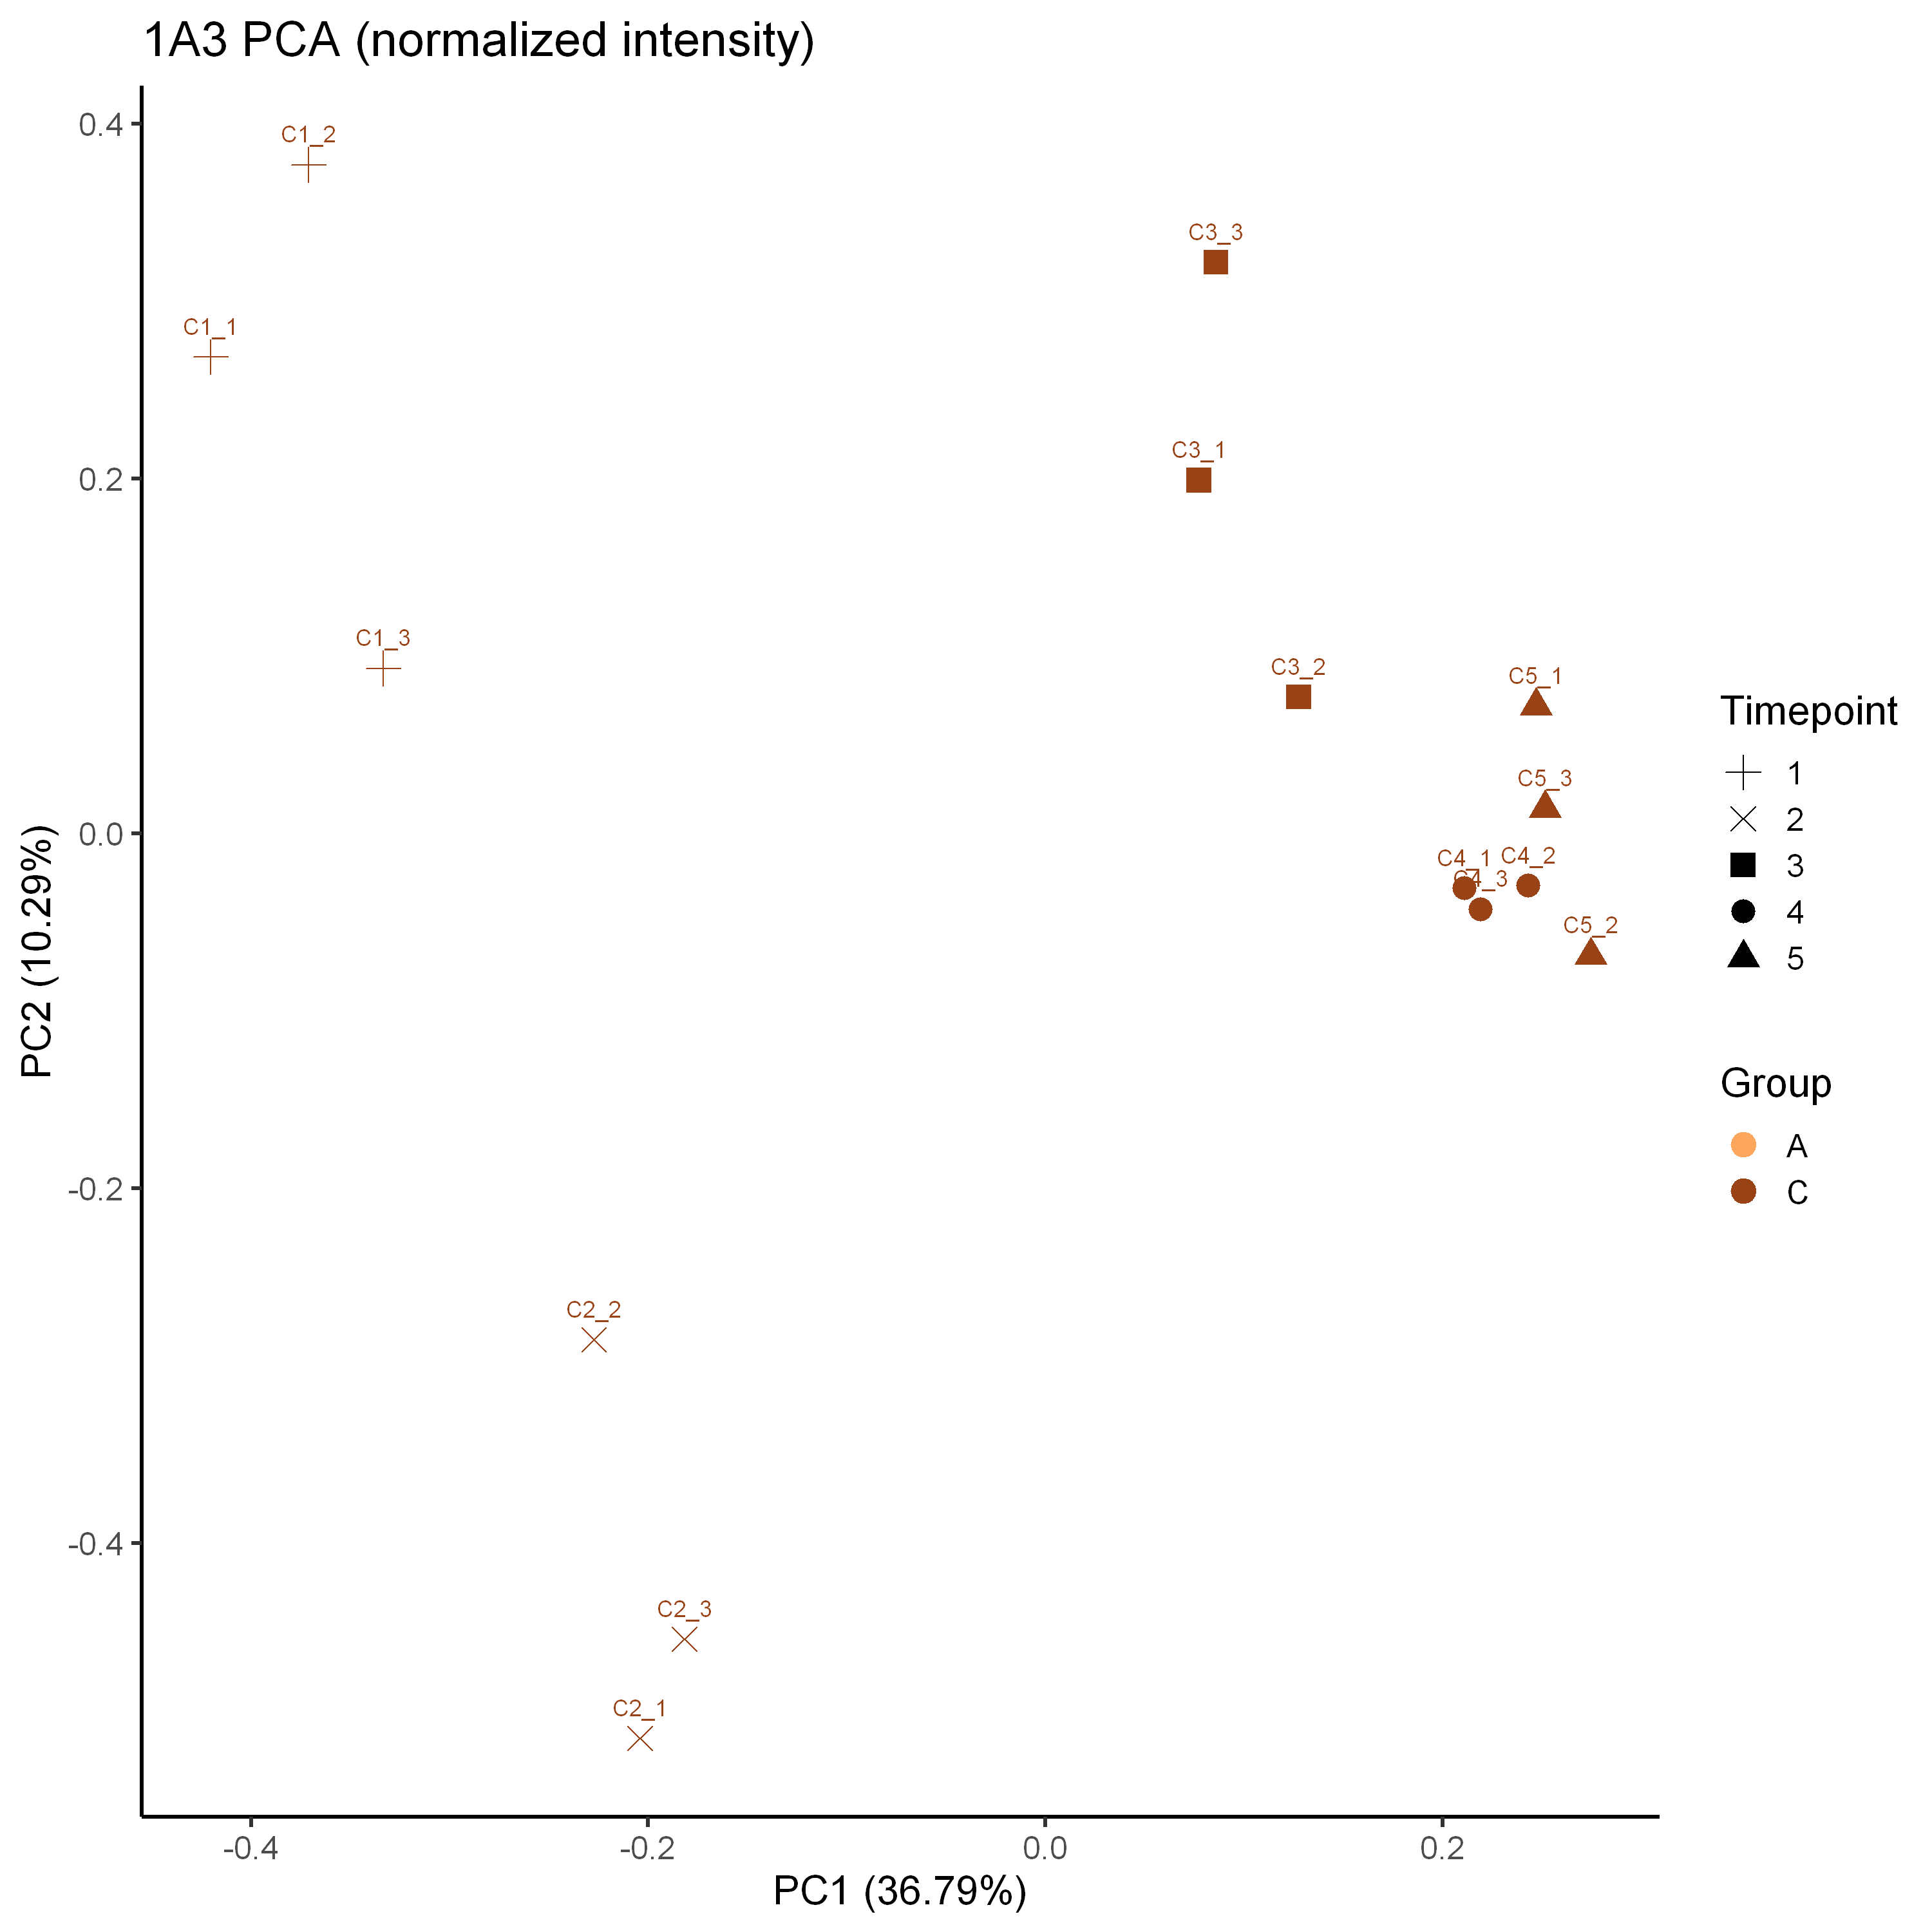

In [90]:
df = pivot_wider(
    mdf, id_cols=c('Sample', 'Group','Timepoint','replicate','Group.Timepoint'), 
    names_from='protein_id', values_from = 'Intensity') 
df = df %>% filter(Group=='C')
X = df %>% select(starts_with('WP_')) 
row.names(X) = df$Sample
#X
#    as.data.frame
pca_res <- prcomp(X, scale. = TRUE)
autoplot(pca_res, data=df, colour='Group', shape='Timepoint', label=TRUE, size =4, 
         label.vjust = -1.3, label.size = 3) +
  scale_color_manual(values = ann_colors$Group) +
  scale_shape_manual(values=c(3,4, 15,16,17))+
  ggtitle("1A3 PCA (normalized intensity)") +
  theme_classic(base_size = 15)  


In [92]:
names(mdf)

[1] "Species"         "name"            "protein_id"      "Sample"         
[5] "Intensity"       "Group"           "Timepoint"       "replicate"      
[9] "Group.Timepoint"

`summarise()` has grouped output by 'protein_id'. You can override using the `.groups` argument.


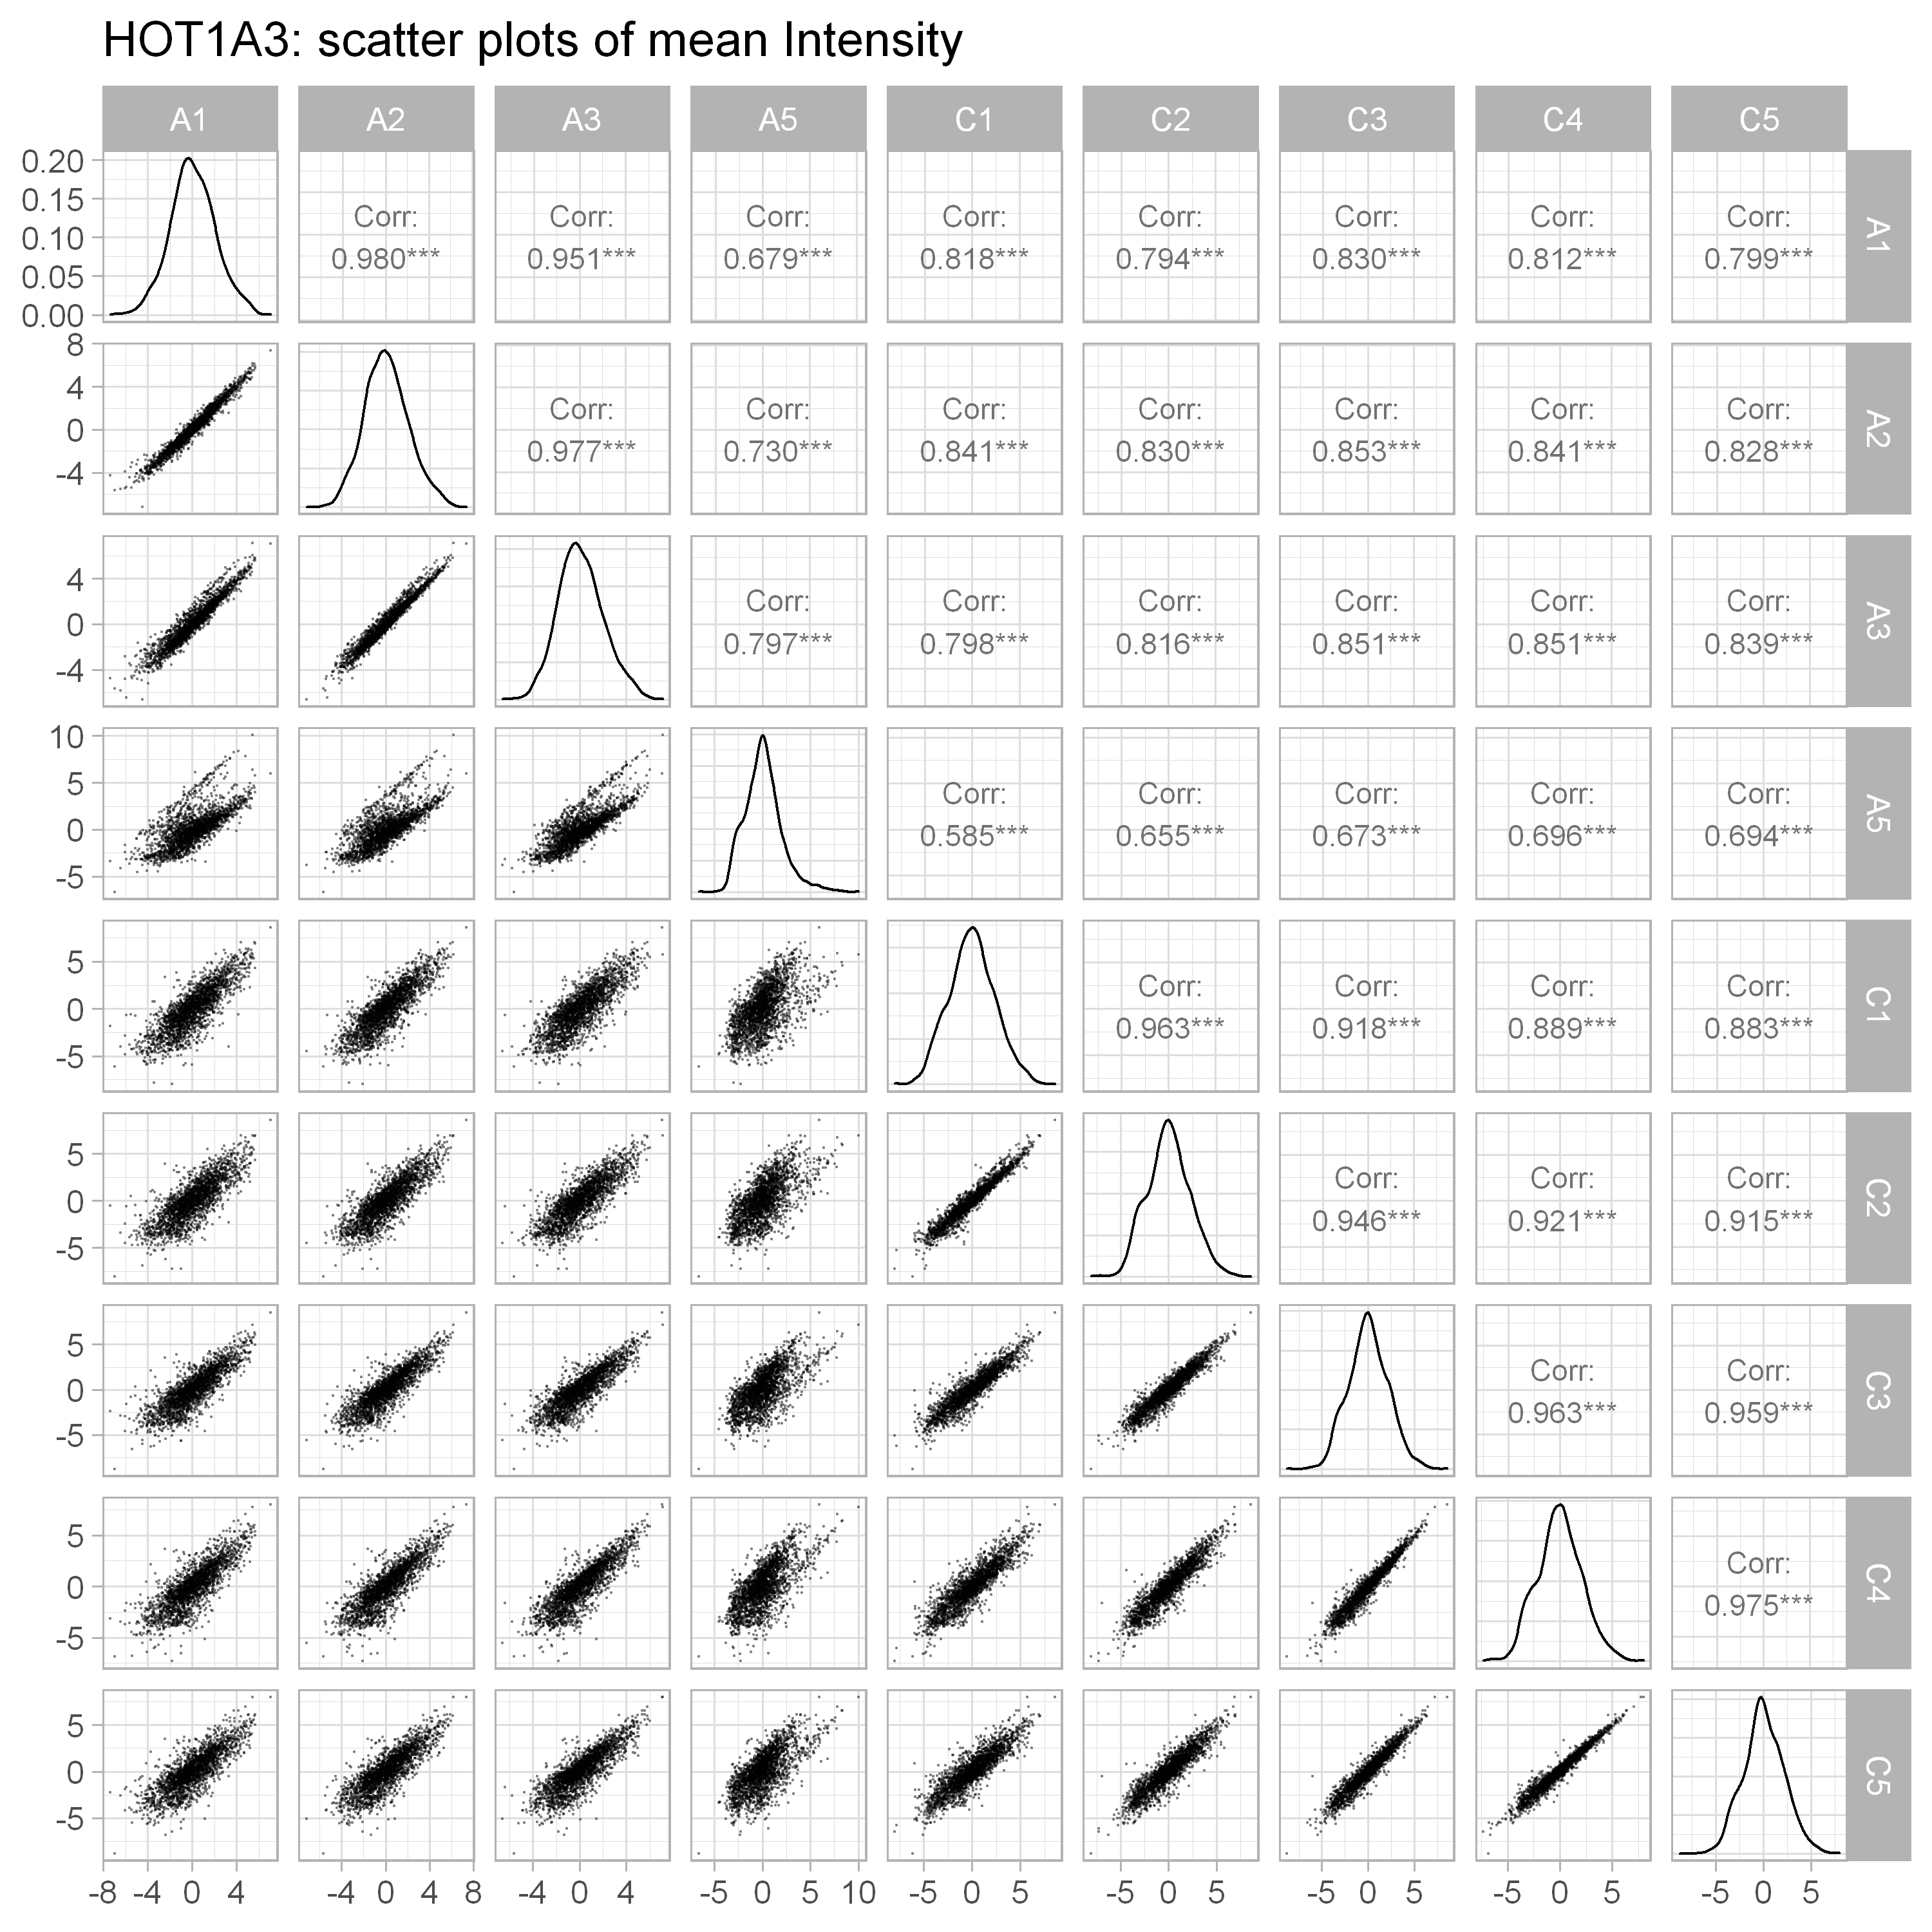

In [100]:
mdf %>%
   group_by(protein_id, Group.Timepoint)  %>%
   summarise(mean_Intensity = mean(Intensity)) %>%
   pivot_wider(names_from = Group.Timepoint, values_from = mean_Intensity) %>%
ggpairs(columns = c(2:10), lower = list(continuous = wrap("points", alpha = 0.3, size=0.1)),
        title='HOT1A3: scatter plots of mean Intensity'
       ) +
  theme_light(base_size = 15)
  
   

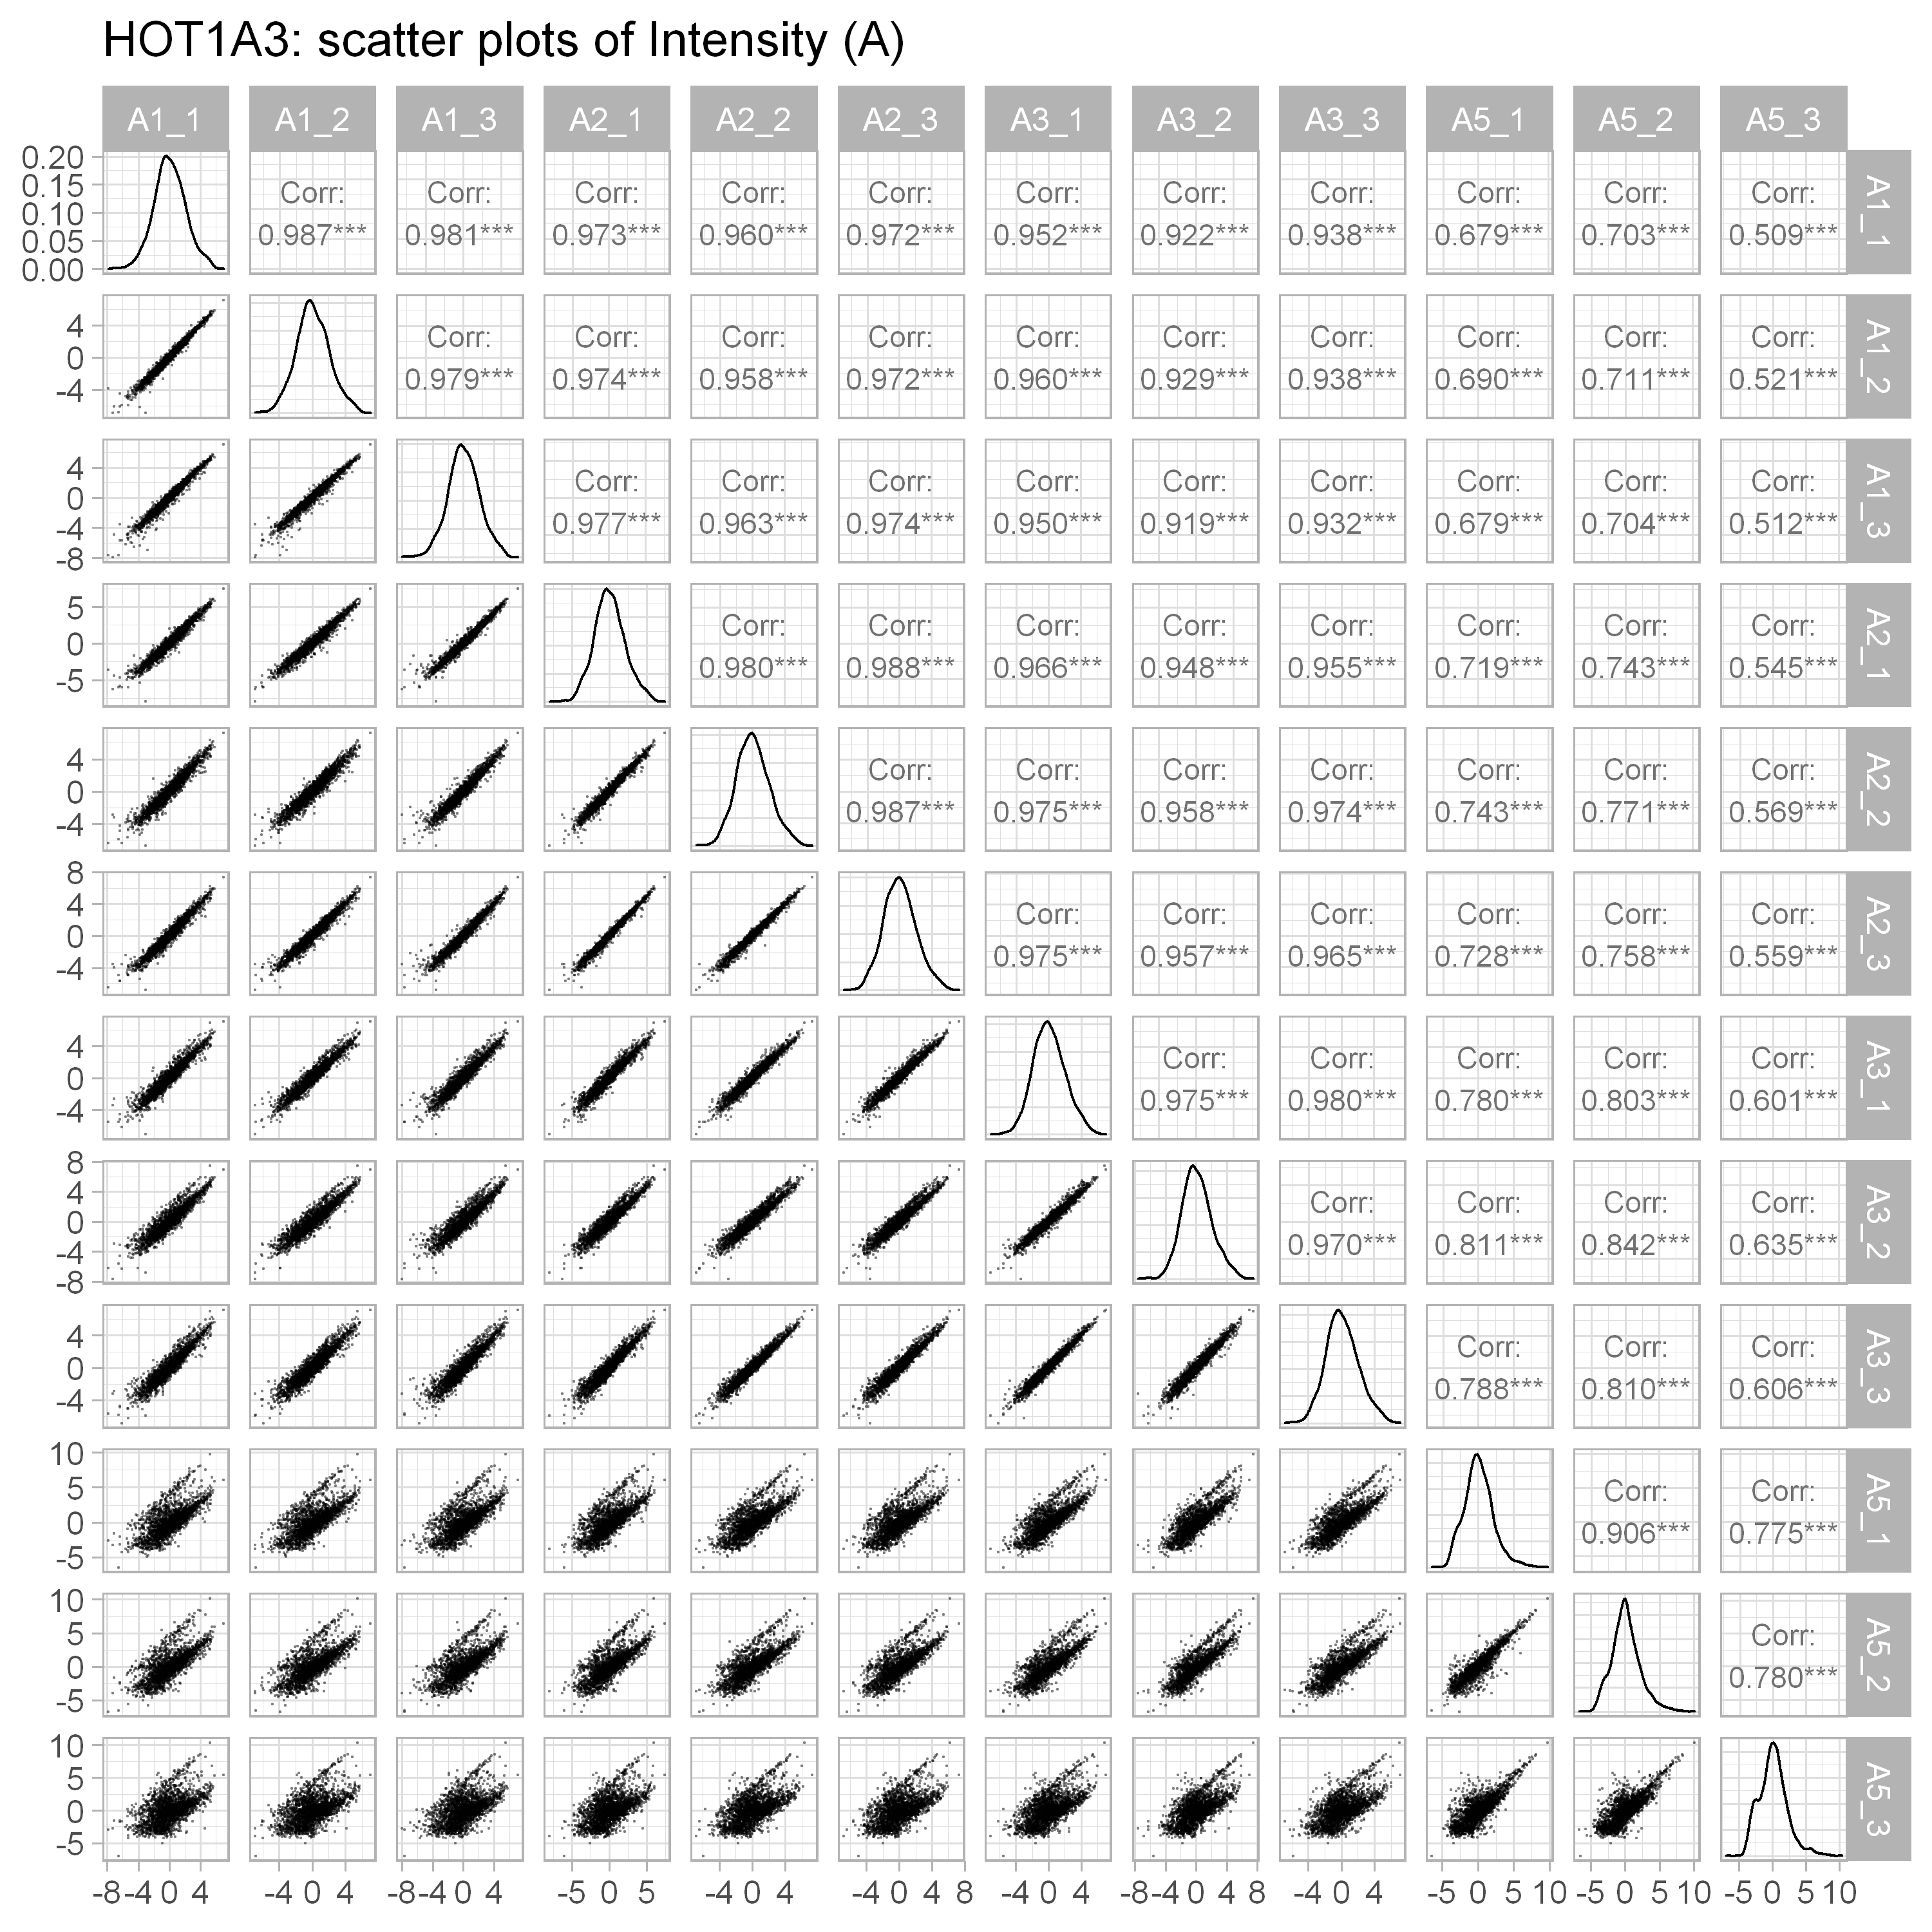

In [113]:
mdf %>%

   filter(Group == 'A') %>%
   select(Sample, Intensity, protein_id) %>%
   #group_by(protein_id, Group.Timepoint)  %>%
   #summarise(mean_Intensity = mean(Intensity)) %>%
   pivot_wider(names_from = Sample, values_from = Intensity) %>%
ggpairs(columns = c(2:13), lower = list(continuous = wrap("points", alpha = 0.3, size=0.1)),
        title='HOT1A3: scatter plots of Intensity (A)'
       ) +
  theme_light(base_size = 15)
  
   

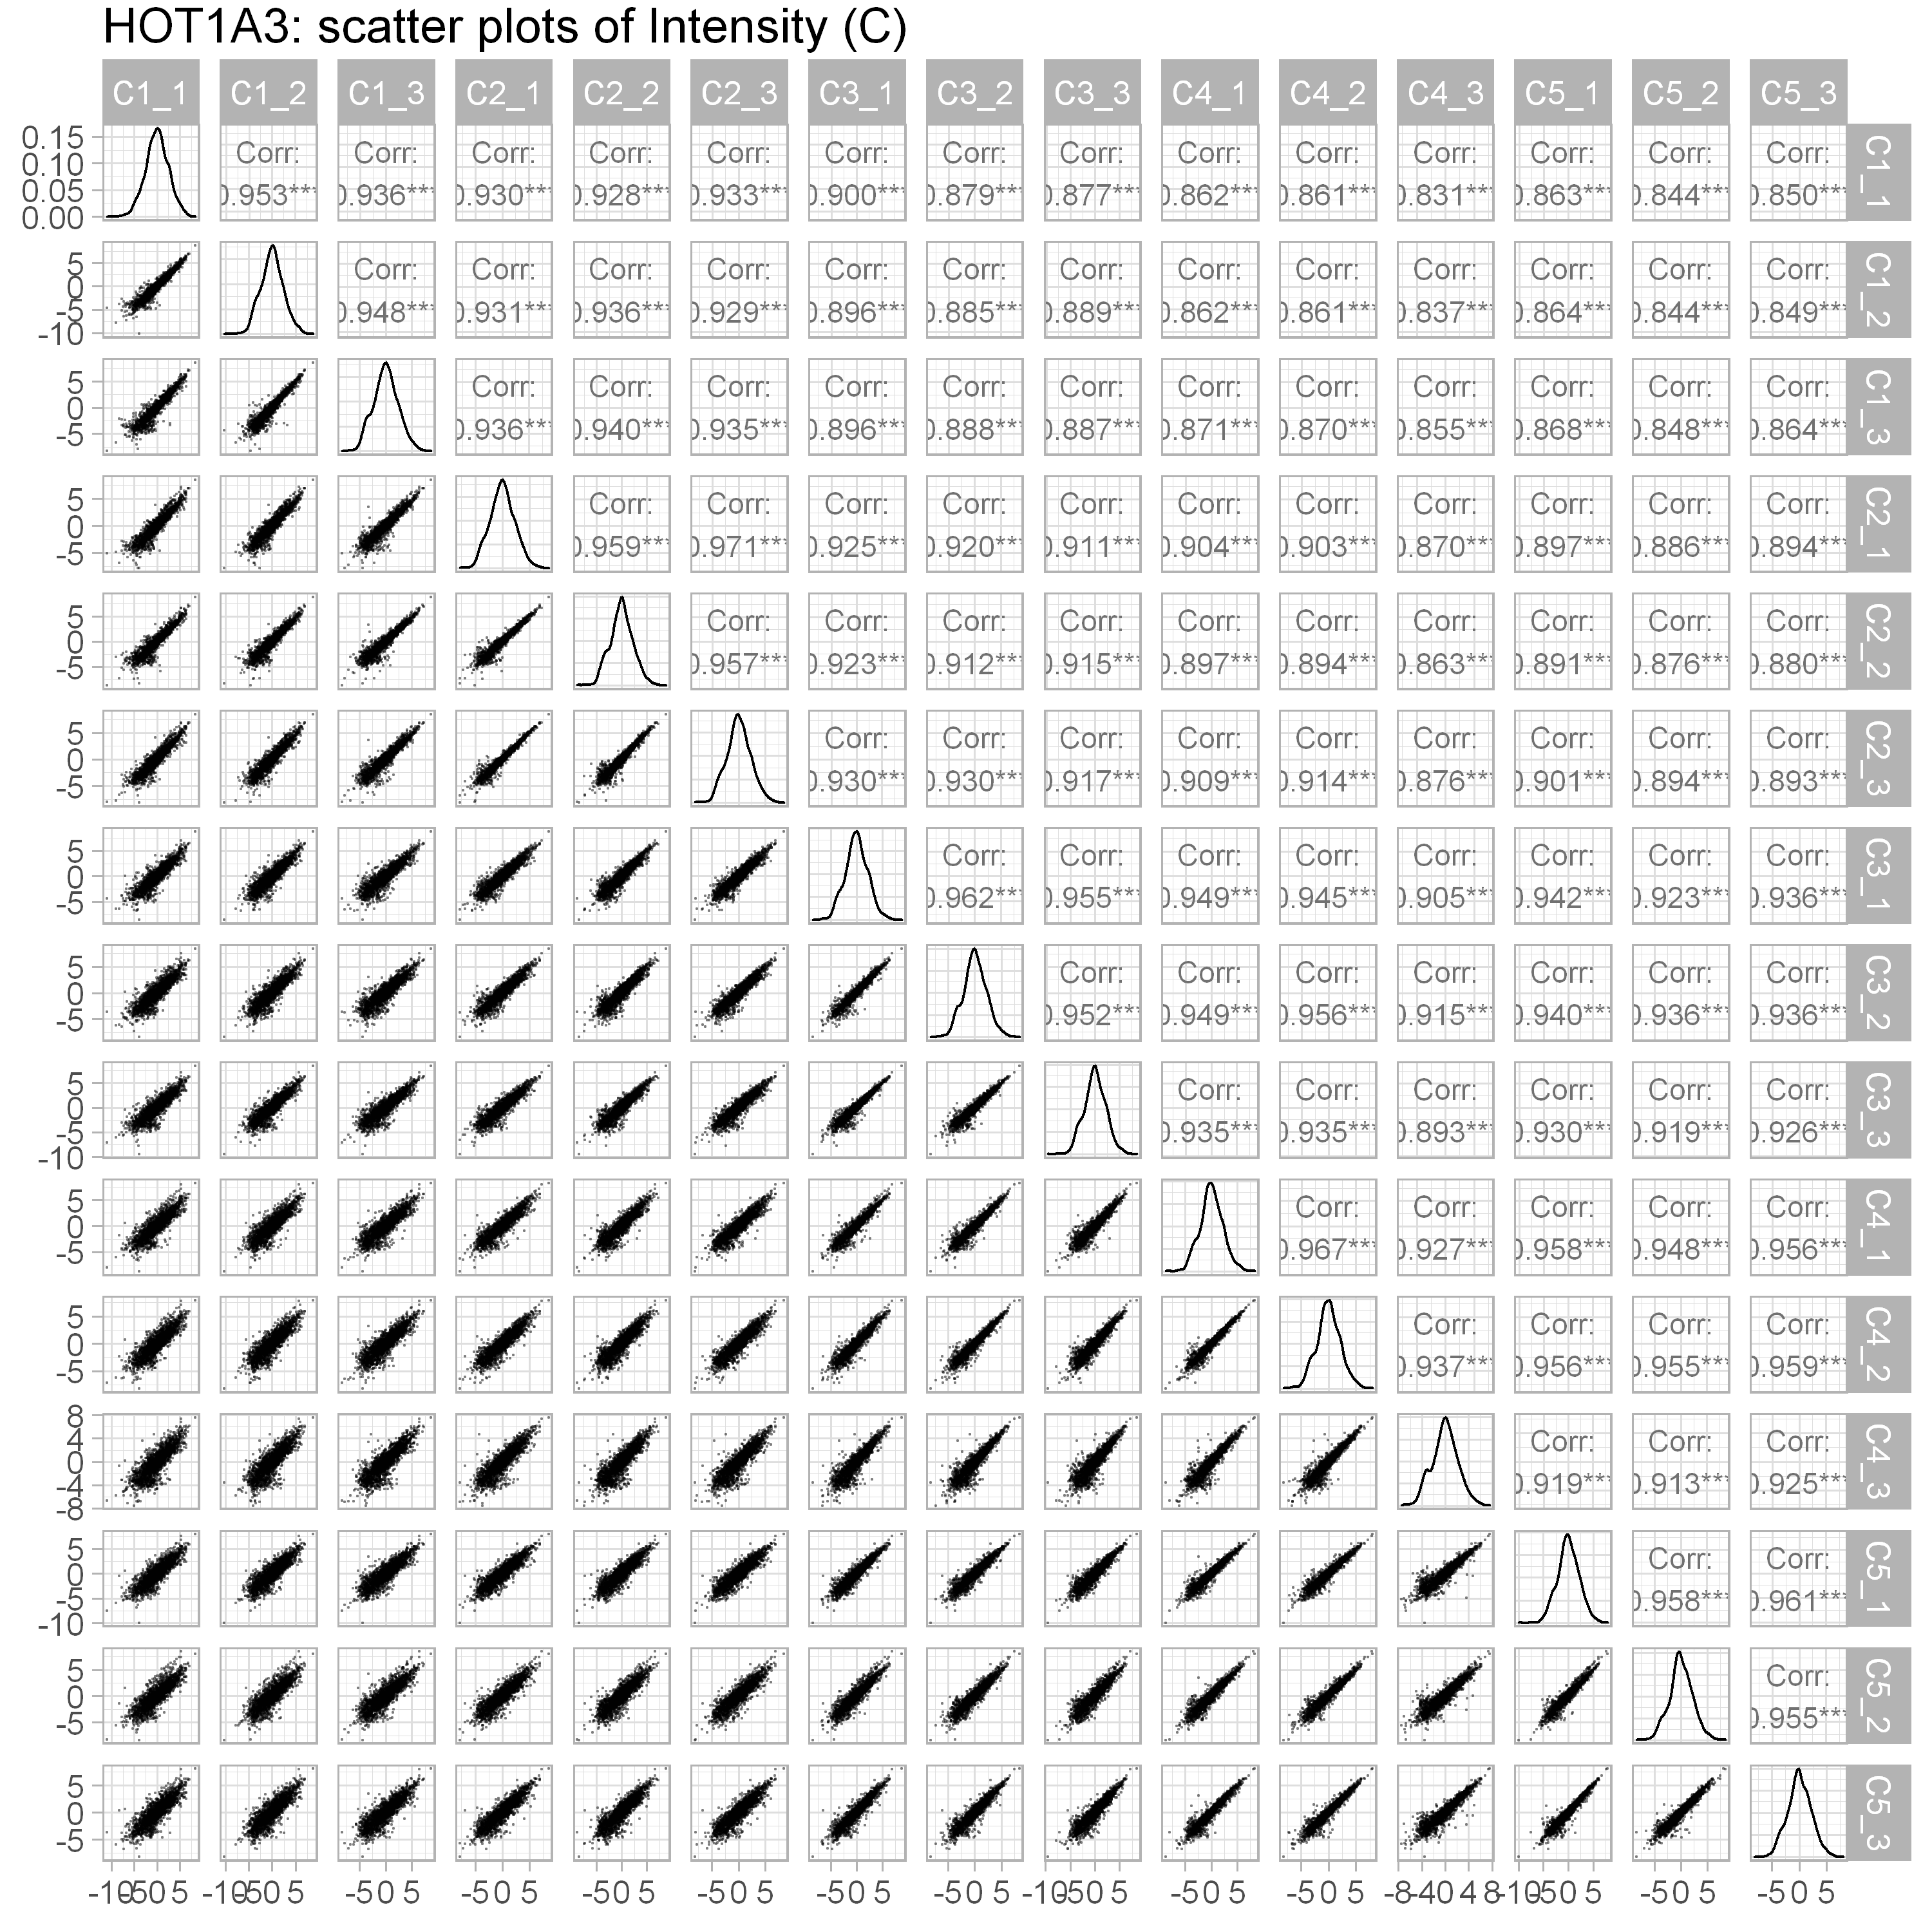

In [112]:
mdf %>%

   filter(Group == 'C') %>%
   select(Sample, Intensity, protein_id) %>%
   #group_by(protein_id, Group.Timepoint)  %>%
   #summarise(mean_Intensity = mean(Intensity)) %>%
   pivot_wider(names_from = Sample, values_from = Intensity) %>%
ggpairs(columns = c(2:16), lower = list(continuous = wrap("points", alpha = 0.3, size=0.1)),
        title='HOT1A3: scatter plots of Intensity (C)'
       ) +
  theme_light(base_size = 15)
  
   

In [17]:
head(df)

Sample,Group,Timepoint,replicate,Group.Timepoint,WP_061485087.1,WP_014950040.1,WP_014951106.1,WP_014977470.1,WP_039226539.1,⋯,WP_014949526.1,WP_061487061.1,WP_061485156.1,WP_014949936.1,WP_061439078.1,WP_014950566.1,WP_014948075.1,WP_039227006.1,WP_061439403.1,WP_061439265.1
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1_1,A,1,1,A1,5.240101,3.701227,4.682087,2.965889,3.962784,⋯,-5.295685,-2.790648,-2.916712,-7.091400,-6.363543,-2.676935,-4.785130,-6.501520,-4.956932,-2.504217
A1_2,A,1,2,A1,5.525033,3.928233,4.858302,3.316838,4.359653,⋯,-5.952418,-3.115626,-3.151870,-6.072566,-6.060117,-2.694402,-4.111754,-6.810218,-5.286328,-4.296359
A1_3,A,1,3,A1,5.519694,3.618751,4.771359,3.113040,4.099994,⋯,-5.608193,-6.931130,-2.633283,-4.892135,-5.708186,-2.618779,-4.387052,-7.672246,-5.943851,-3.277011
A2_1,A,2,1,A2,6.025249,4.446682,5.213707,3.706350,4.651552,⋯,-6.028896,-2.869167,-3.179237,-4.446014,-5.800470,-2.080486,-3.850941,-5.989988,-3.669329,-3.295624
A2_2,A,2,2,A2,6.314917,4.505447,5.421755,3.806171,4.568499,⋯,-3.258360,-1.947500,-2.940903,-3.192232,-4.905684,-3.094650,-4.148979,-5.965317,-2.556681,-2.802128
A2_3,A,2,3,A2,6.192062,4.471663,5.446032,3.753826,4.627104,⋯,-3.929897,-2.194944,-3.889816,-3.954996,-5.622826,-2.225124,-3.846884,-4.956461,-2.882446,-3.040699


In [19]:
cdf = pivot_wider(
    mdf, id_cols=c('protein_id'), 
    names_from='Sample', values_from = 'Intensity') %>% column_to_rownames('protein_id')

head(cdf)

,A1_1,A1_2,A1_3,A2_1,A2_2,A2_3,A3_1,A3_2,A3_3,A5_1,⋯,C2_3,C3_1,C3_2,C3_3,C4_1,C4_2,C4_3,C5_1,C5_2,C5_3
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WP_061485087.1,5.240101,5.525033,5.519694,6.025249,6.314917,6.192062,6.871571,7.469327,7.003351,9.730481,⋯,6.861284,6.981548,7.468564,7.153864,8.065987,7.849881,7.390442,7.547355,8.466634,8.003884
WP_014950040.1,3.701227,3.928233,3.618751,4.446682,4.505447,4.471663,5.310719,5.660226,5.106373,8.005286,⋯,6.204288,5.598722,6.261405,5.863708,6.780481,6.579415,5.680281,6.025517,7.465961,6.172181
WP_014951106.1,4.682087,4.858302,4.771359,5.213707,5.421755,5.446032,5.576603,5.899587,5.925354,7.562854,⋯,6.752094,6.267843,6.665971,6.413103,7.161934,7.143355,6.863058,6.762584,7.473516,6.755948
WP_014977470.1,2.965889,3.316838,3.113040,3.706350,3.806171,3.753826,4.293076,4.894555,4.421509,7.220067,⋯,4.898666,4.517380,4.941028,4.613556,5.642513,5.489058,5.056116,5.079972,6.106339,5.299033
WP_039226539.1,3.962784,4.359653,4.099994,4.651552,4.568499,4.627104,5.420404,5.902137,5.359781,8.116076,⋯,6.081018,6.111351,6.354207,6.116280,6.649420,6.498639,6.047241,6.101972,7.088273,6.382001
WP_014977498.1,6.967493,7.084174,7.056806,7.471640,7.223635,7.328812,7.039551,7.002307,7.127415,6.063968,⋯,8.468773,8.780668,8.393146,8.486547,8.328495,7.957679,7.651207,7.890763,8.063817,8.063863


In [22]:
spearman_cor = cor(cdf, method='spearman')
pearson_cor = cor(cdf, method='pearson')


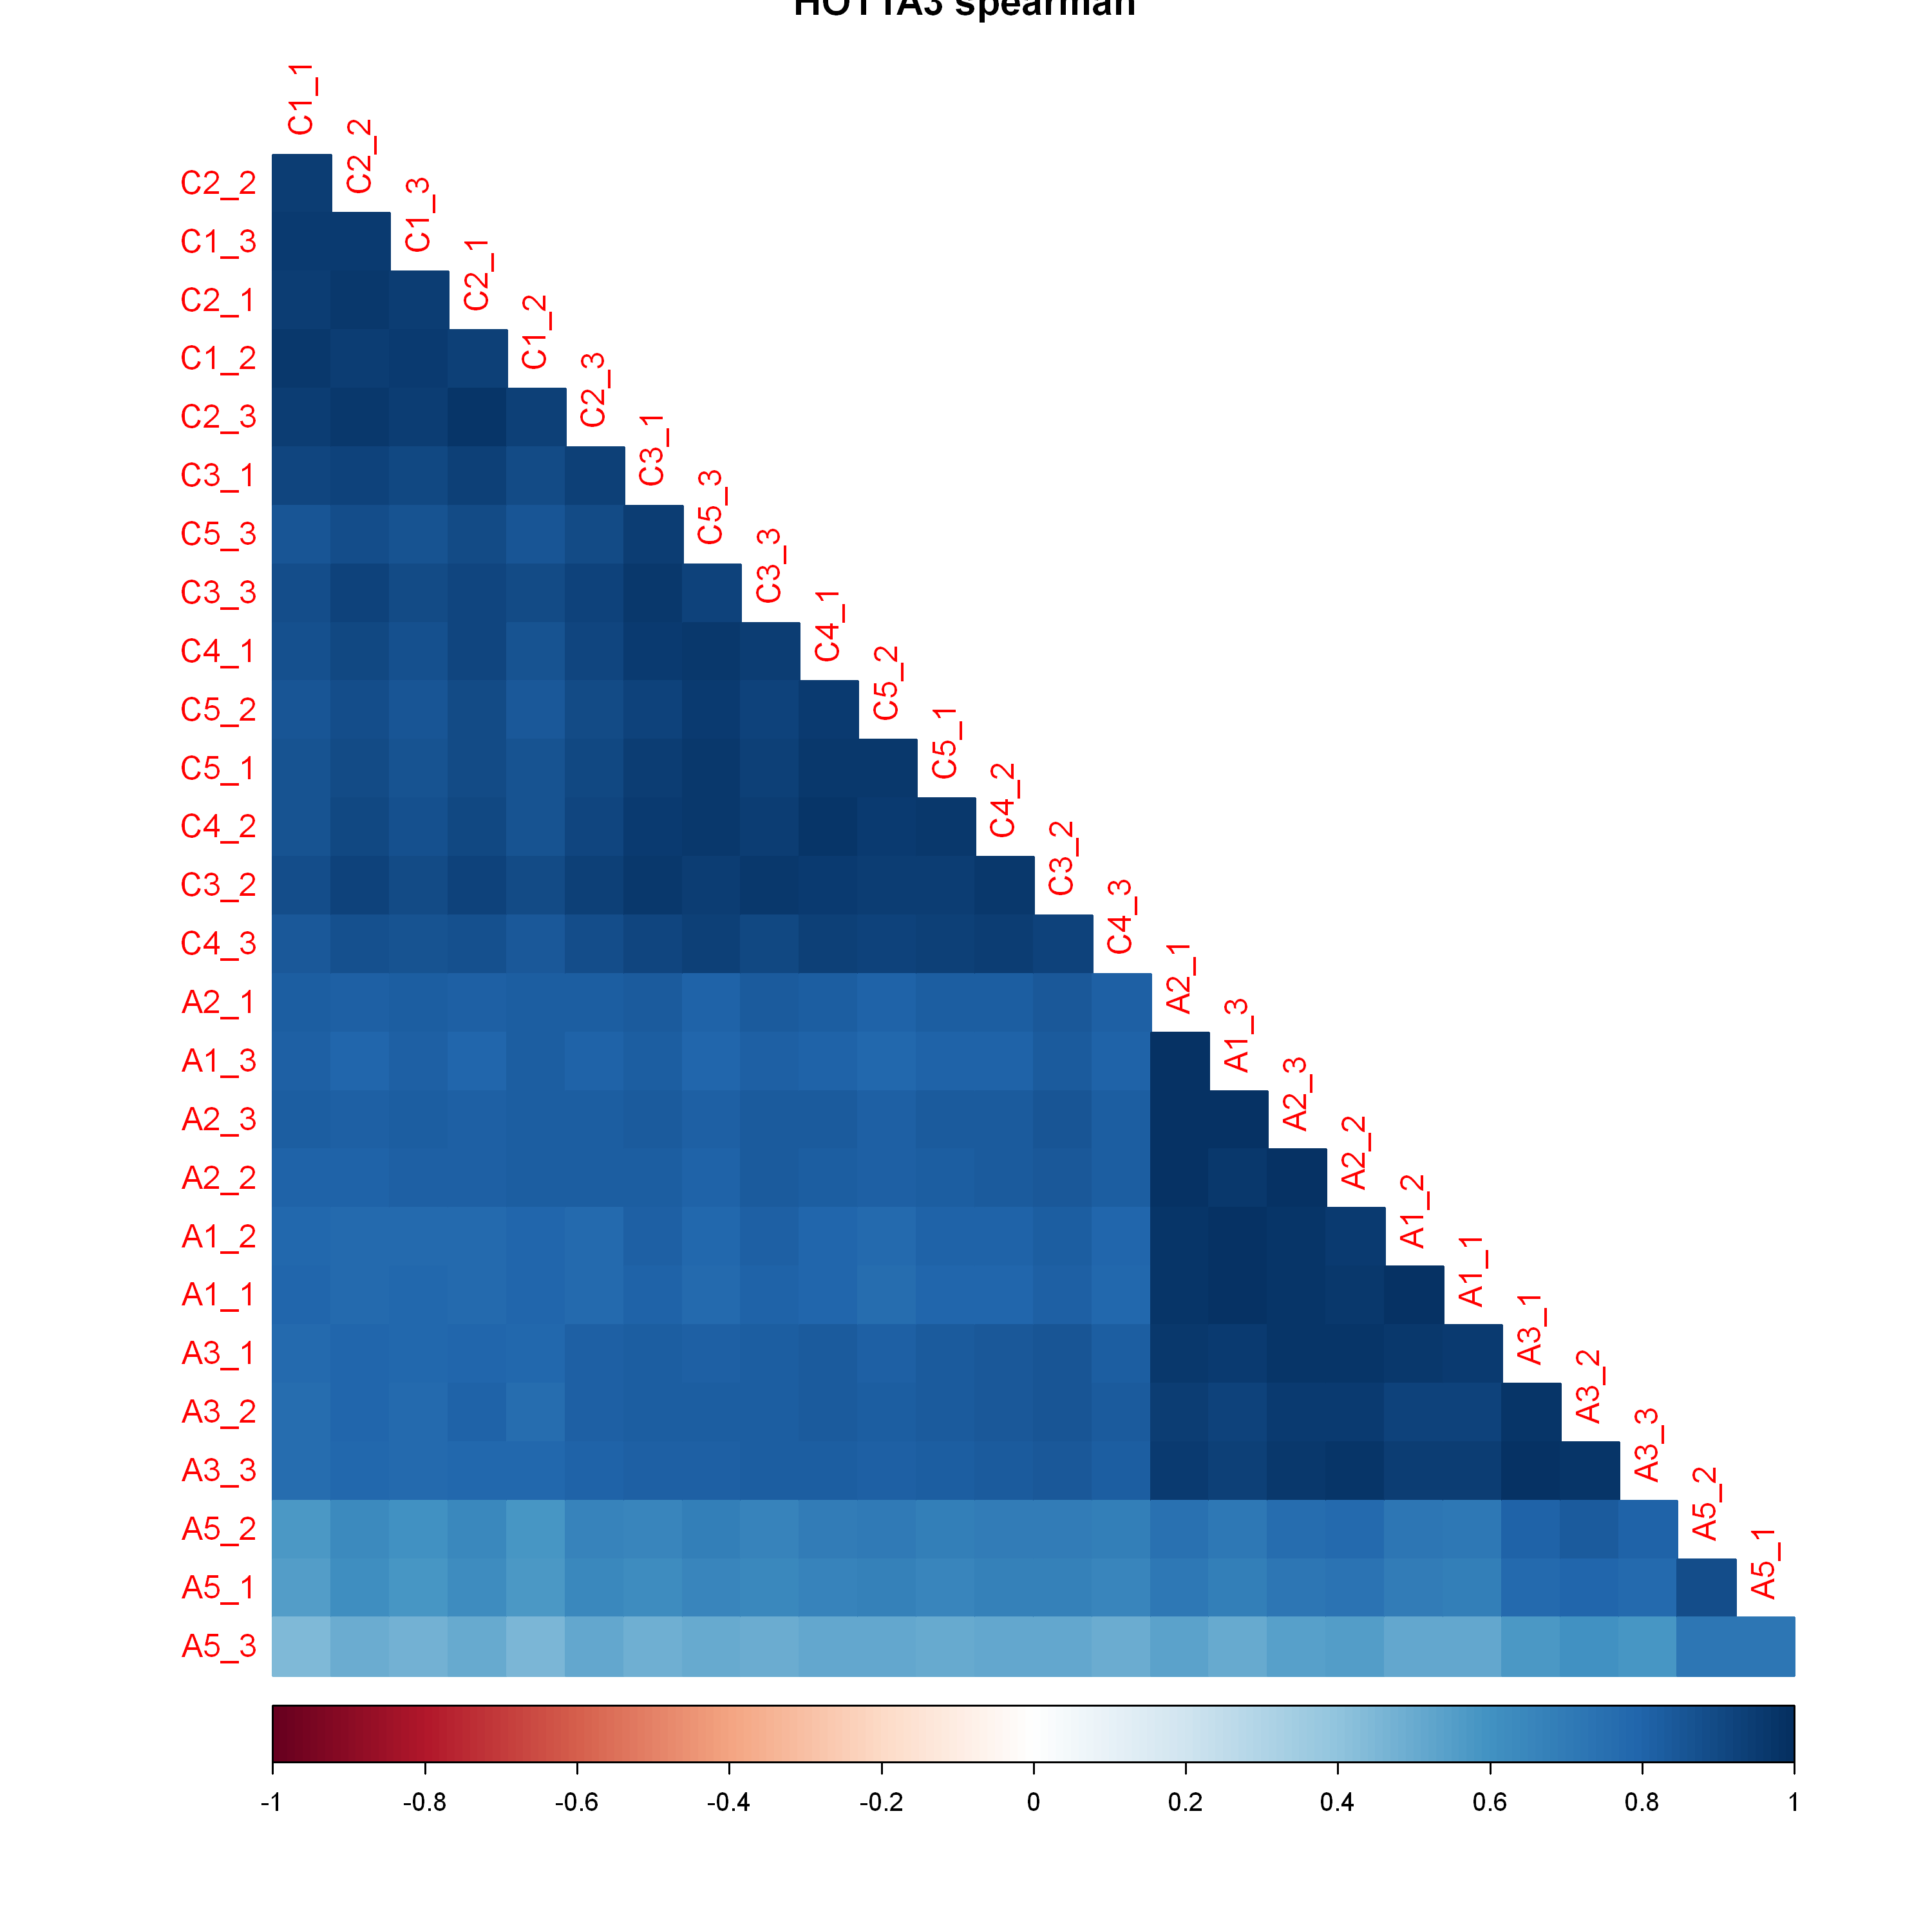

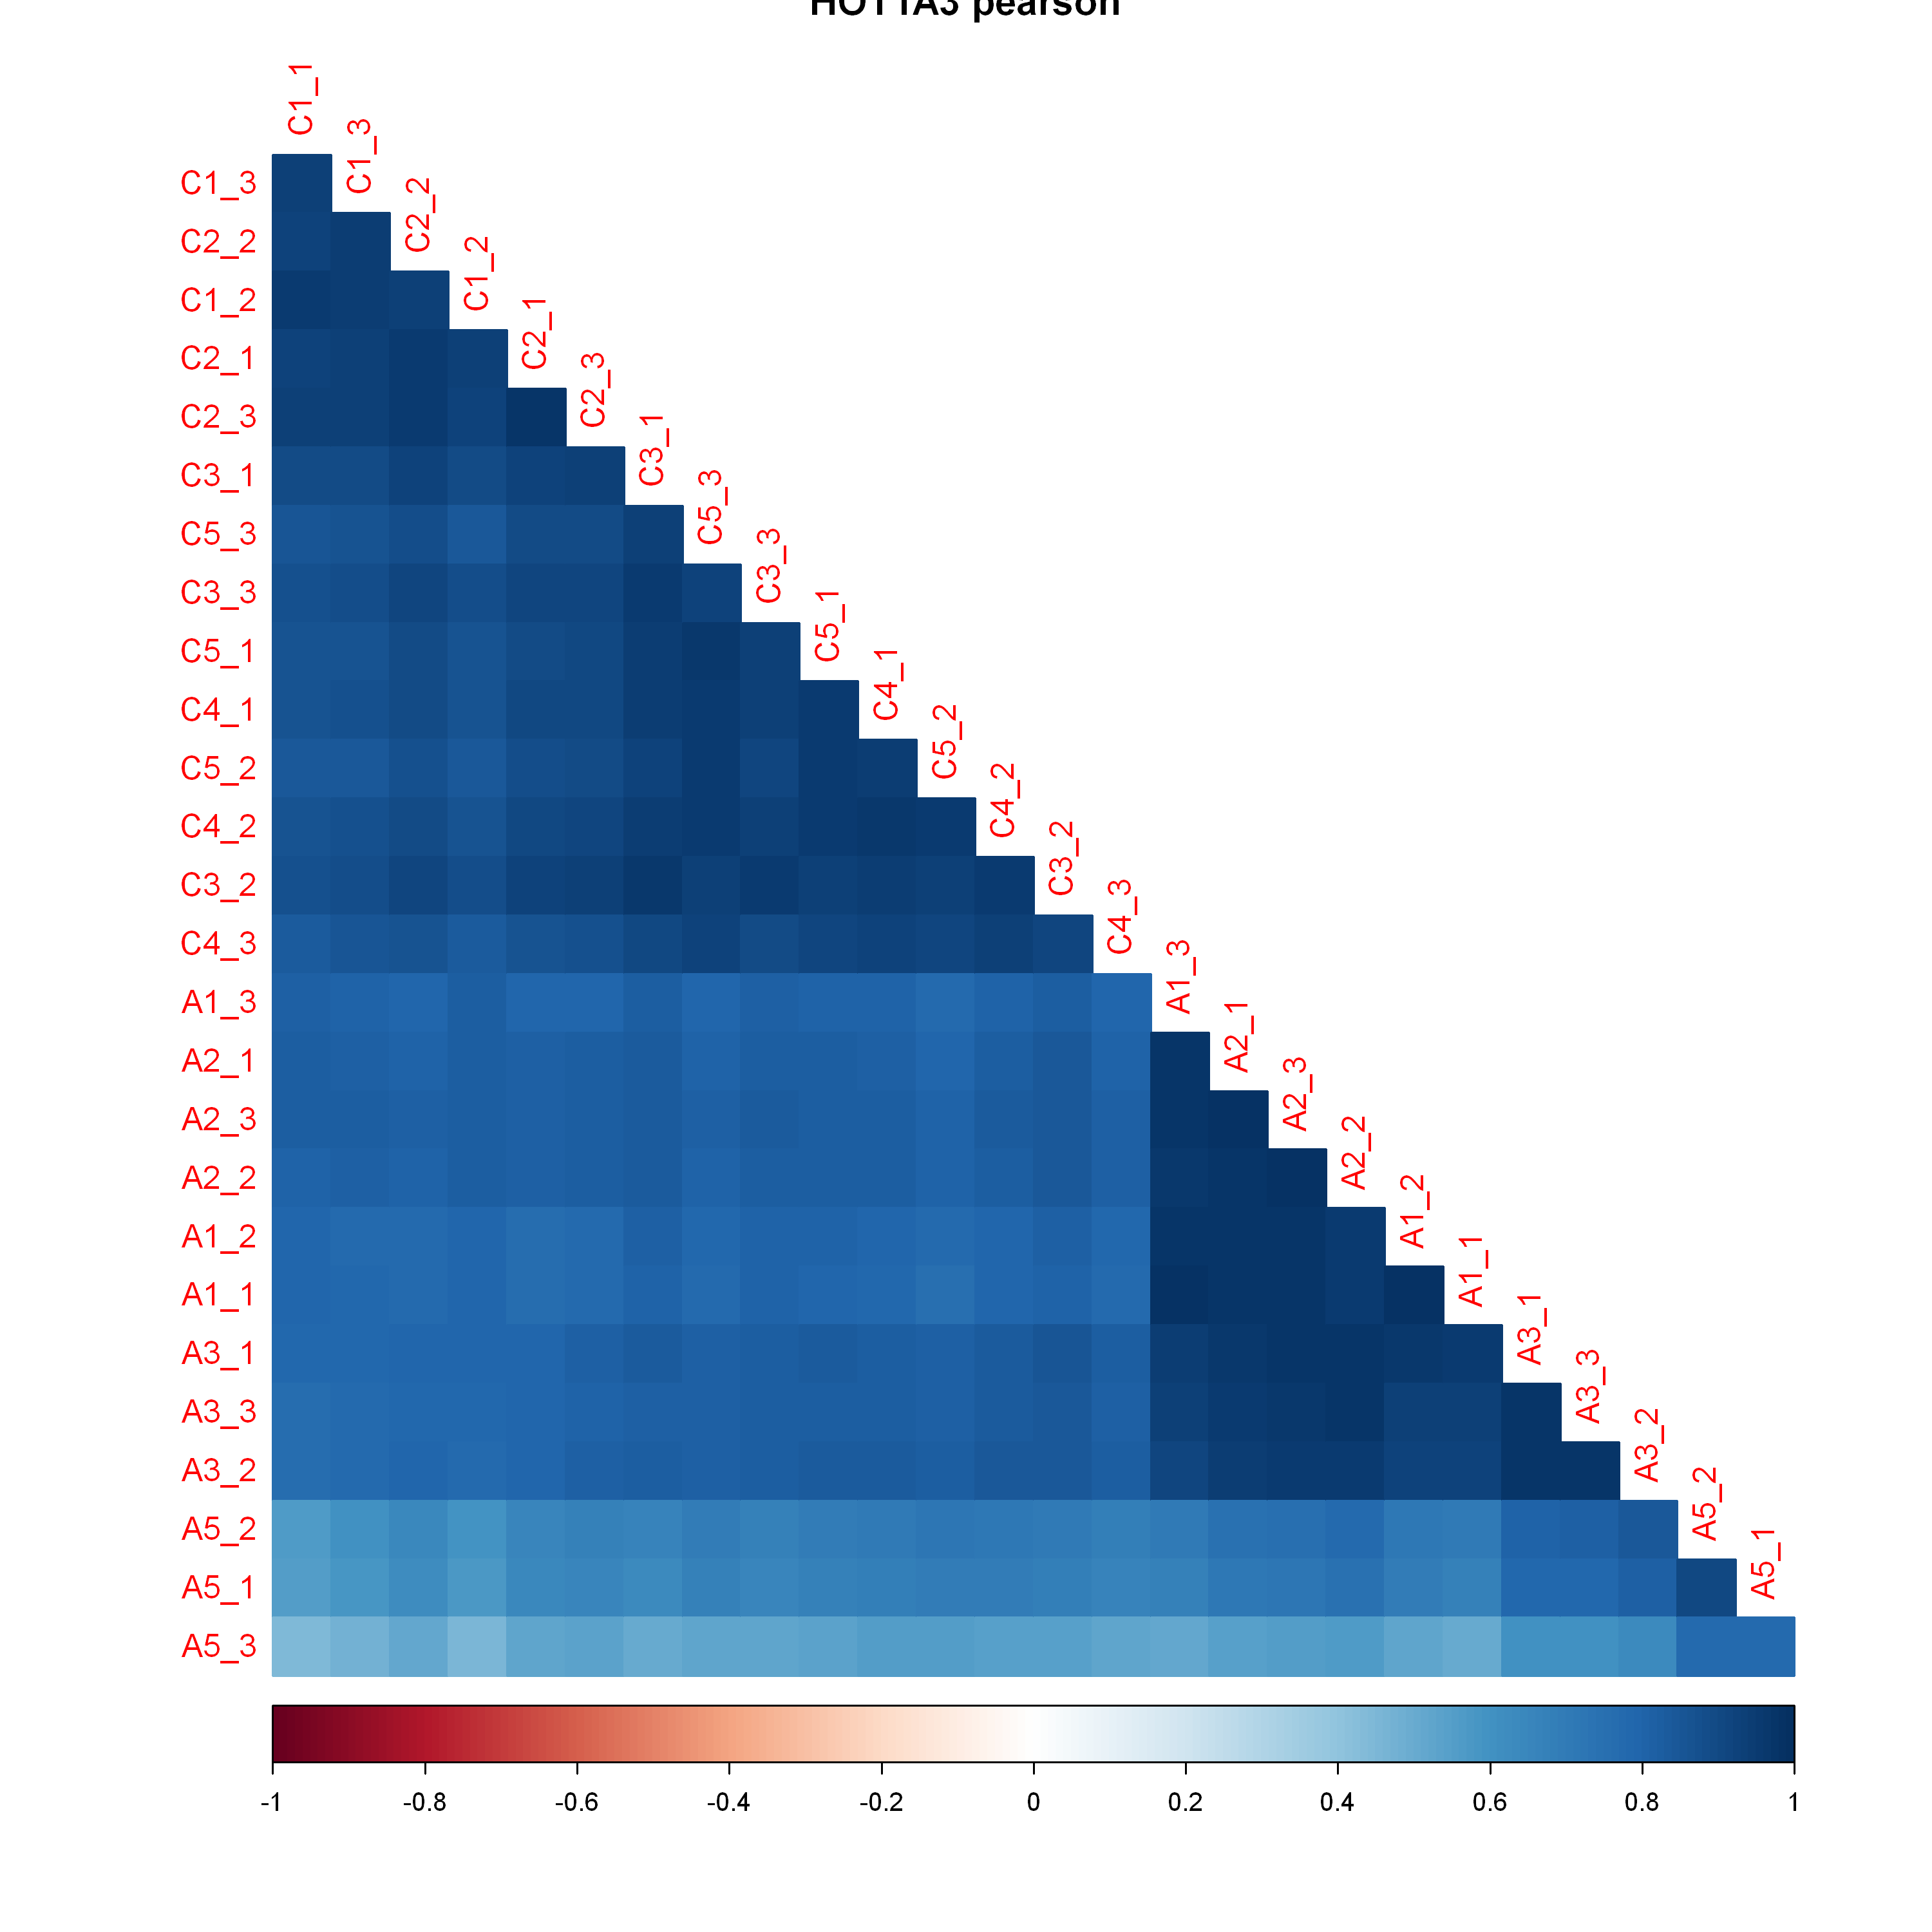

In [39]:
corrplot(spearman_cor, method="color", #tl.cex = .35, 
         order = 'AOE', diag = FALSE, type = 'lower', title='HOT1A3 spearman')
corrplot(pearson_cor, method="color", #tl.cex = .35, 
         order = 'AOE', diag = FALSE, type = 'lower',title='HOT1A3 pearson')


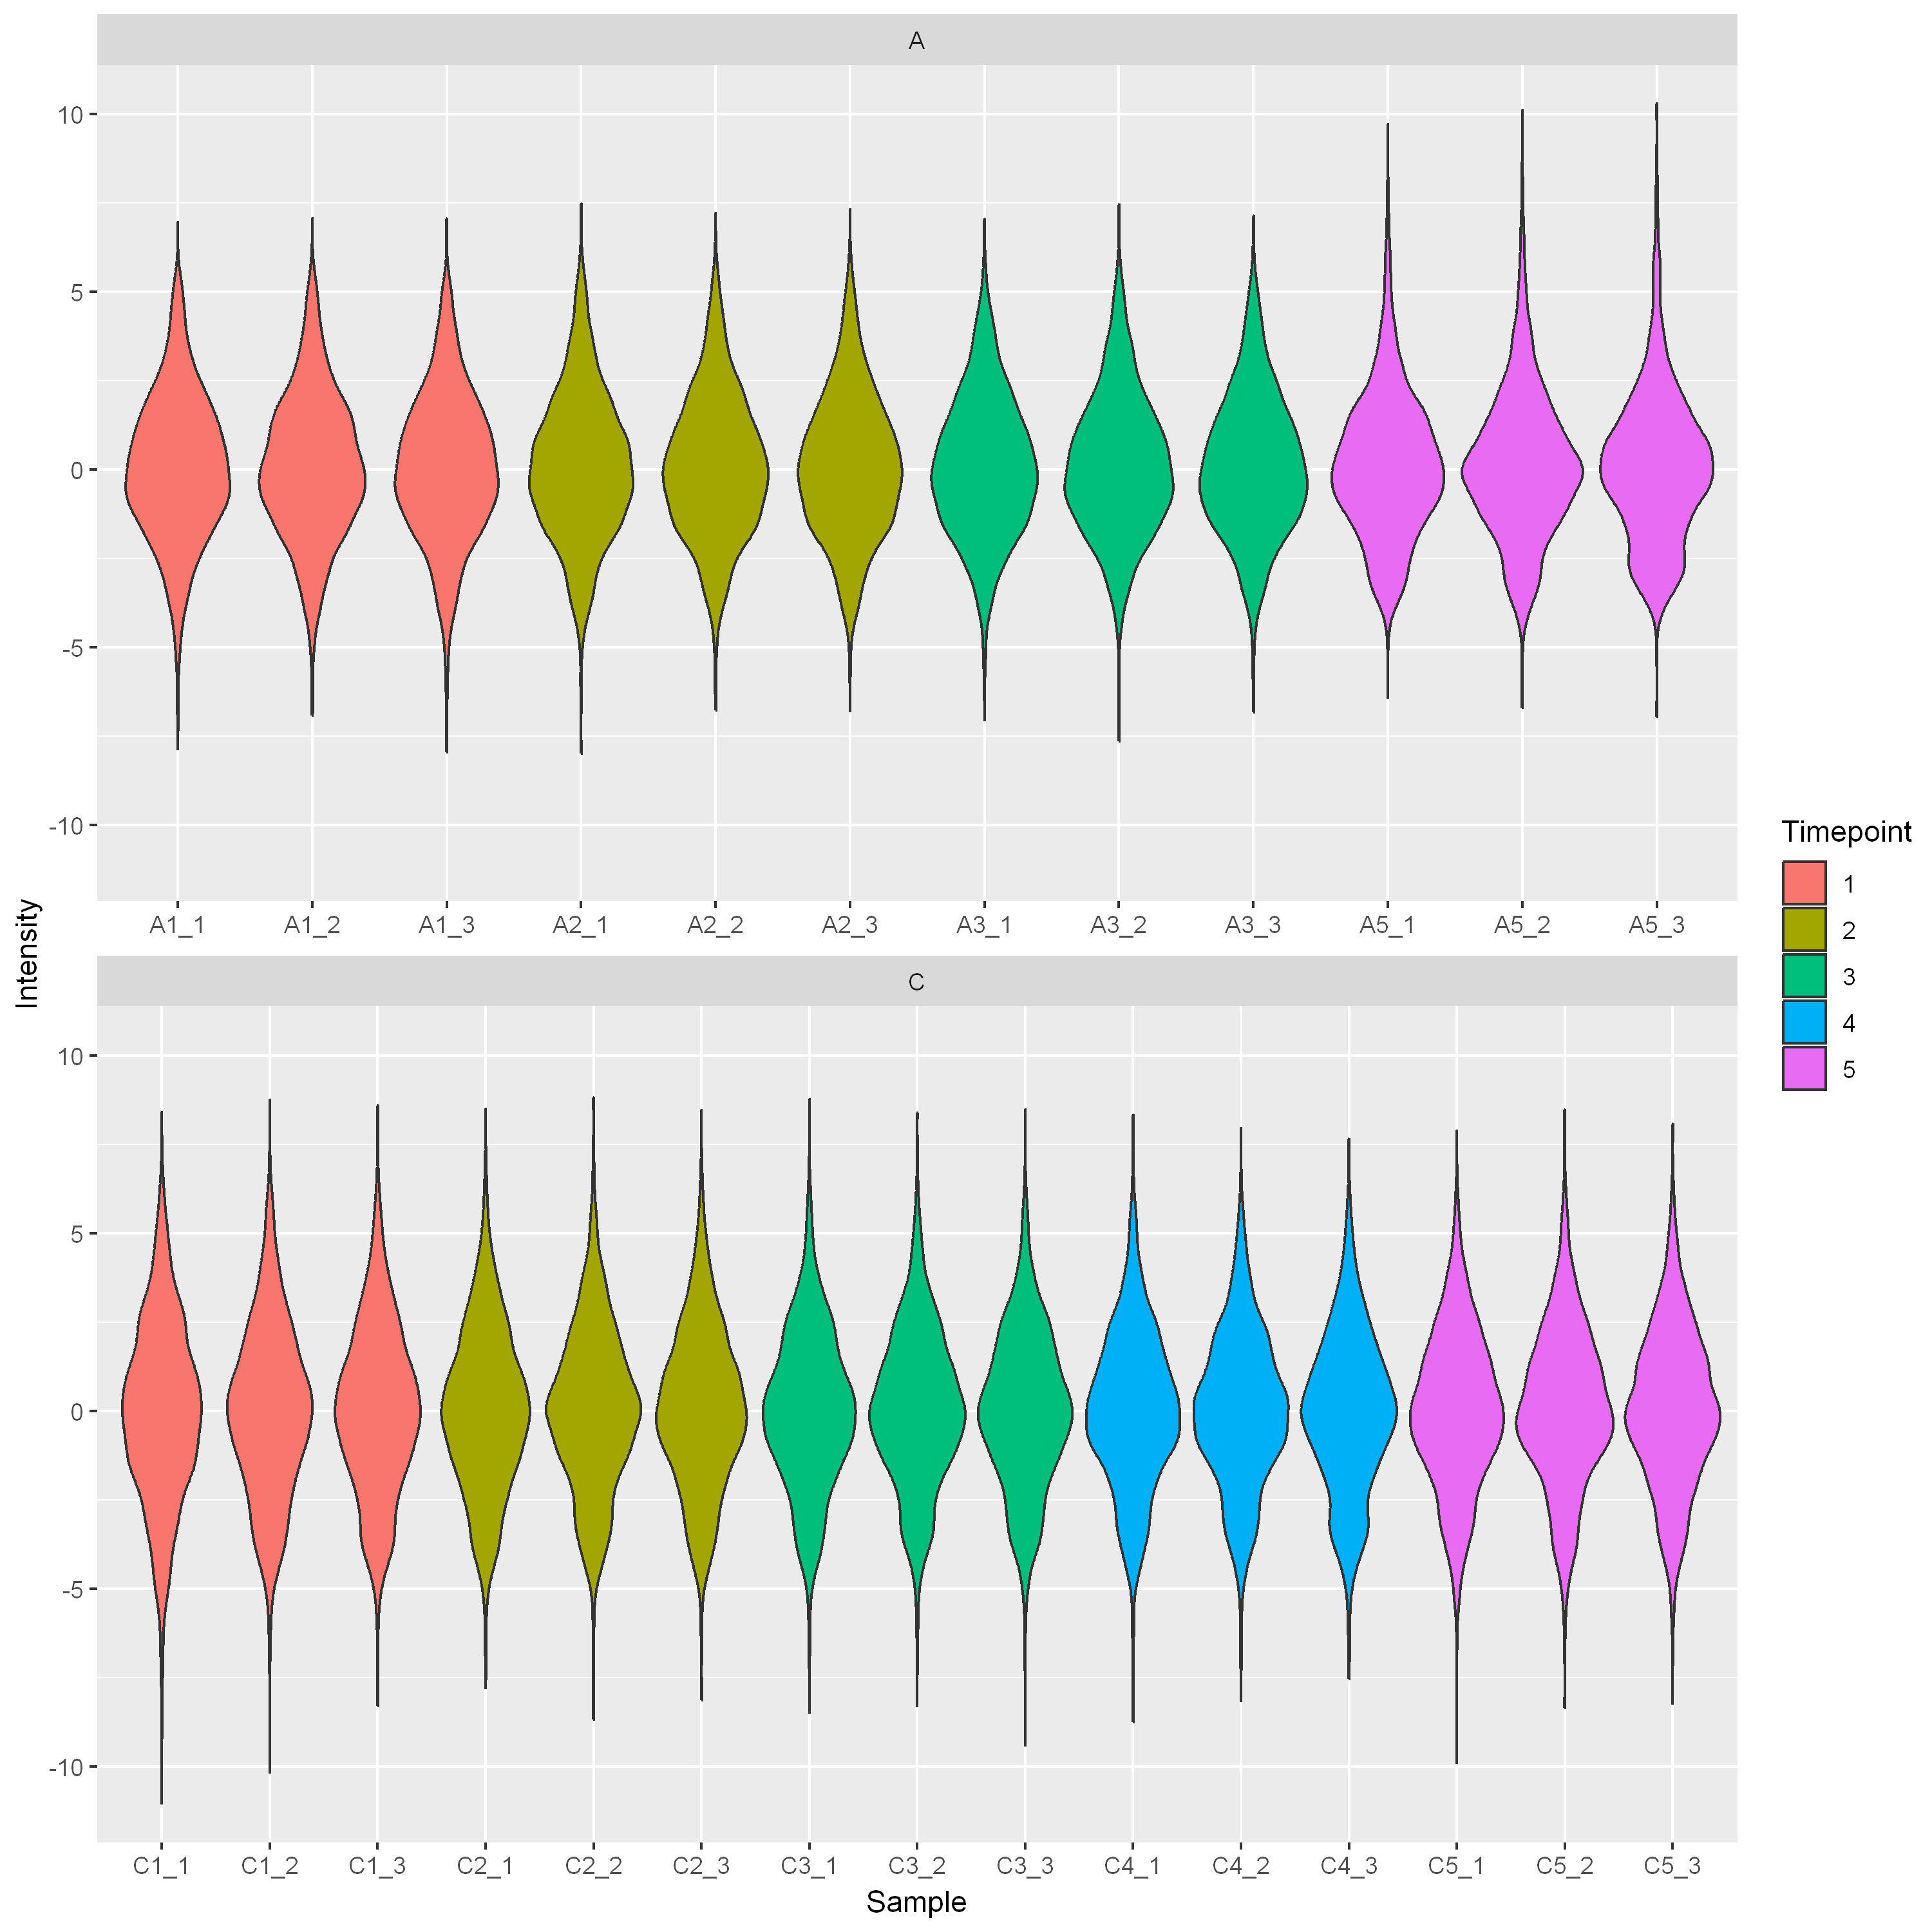

In [40]:
mdf %>%
ggplot(aes(x=Sample, y=Intensity, fill=Timepoint)) +
   geom_violin() +
facet_wrap(~Group, scales = "free_x", ncol=1)

In [41]:
head(mdf)

Species,name,protein_id,Sample,Intensity,Group,Timepoint,replicate,Group.Timepoint
<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
ALT,TonB-dependent receptor,WP_061485087.1,A1_1,5.240101,A,1,1,A1
ALT,TonB-dependent receptor,WP_061485087.1,A1_2,5.525033,A,1,2,A1
ALT,TonB-dependent receptor,WP_061485087.1,A1_3,5.519694,A,1,3,A1
ALT,TonB-dependent receptor,WP_061485087.1,A2_1,6.025249,A,2,1,A2
ALT,TonB-dependent receptor,WP_061485087.1,A2_2,6.314917,A,2,2,A2
ALT,TonB-dependent receptor,WP_061485087.1,A2_3,6.192062,A,2,3,A2


In [43]:
mdf$Timepoint = as.factor(mdf$Timepoint)

In [58]:
mdf$Group.Timepoint = as.factor(mdf$Group.Timepoint)

In [45]:
str(mdf)

tibble [60,048 × 9] (S3: tbl_df/tbl/data.frame)
 $ Species        : chr [1:60048] "ALT" "ALT" "ALT" "ALT" ...
 $ name           : chr [1:60048] "TonB-dependent receptor" "TonB-dependent receptor" "TonB-dependent receptor" "TonB-dependent receptor" ...
 $ protein_id     : chr [1:60048] "WP_061485087.1" "WP_061485087.1" "WP_061485087.1" "WP_061485087.1" ...
 $ Sample         : chr [1:60048] "A1_1" "A1_2" "A1_3" "A2_1" ...
 $ Intensity      : num [1:60048] 5.24 5.53 5.52 6.03 6.31 ...
 $ Group          : chr [1:60048] "A" "A" "A" "A" ...
 $ Timepoint      : Factor w/ 5 levels "1","2","3","4",..: 1 1 1 2 2 2 3 3 3 5 ...
 $ replicate      : chr [1:60048] "1" "2" "3" "1" ...
 $ Group.Timepoint: chr [1:60048] "A1" "A1" "A1" "A2" ...


In [54]:
table(mdf$Group.Timepoint)


  A1   A2   A3   A5   C1   C2   C3   C4   C5 
6672 6672 6672 6672 6672 6672 6672 6672 6672 

In [63]:
#mdf %>% group_by(protein_id, Group)
contrast_list = list(
    c('A1', 'A2'), c('A1', 'A3'), c('A1', 'A4'), c('A1', 'A5'), 
    c('C1', 'C2'), c('C1', 'C3'), c('C1', 'C4'), c('C1', 'C5')
)

mdf %>% filter(Group.Timepoint %in% contrast_list[1]) %>%
group_by(protein_id) %>%
       do(w = wilcox.test(Intensity~ Group.Timepoint, data=., paired=FALSE)) %>% 
       summarise(protein_id, Wilcox = w$p.value)
#summarise(wilcox.test(Intensity~ Timepoint))

ERROR: [1m[33mError[39m in `summarise()`:[22m
[1m[22m[36mℹ[39m In argument: `Wilcox = w$p.value`.
[1mCaused by error in `w$p.value`:[22m
[33m![39m $ operator is invalid for atomic vectors


In [65]:
contrast_list[1]

[[1]]
[1] "A1" "A2"

In [64]:
contrast_list


[[1]]
[1] "A1" "A2"

[[2]]
[1] "A1" "A3"

[[3]]
[1] "A1" "A4"

[[4]]
[1] "A1" "A5"

[[5]]
[1] "C1" "C2"

[[6]]
[1] "C1" "C3"

[[7]]
[1] "C1" "C4"

[[8]]
[1] "C1" "C5"